# Change Point Identification
- ported from python
- to detect change points in the time series of log(var) of gh500 in the North Atlantic
- use monthly data for simplicity and because spatial aggregation makes daily scale inconsistent

In [1]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.1; sf_use_s2() is TRUE

Lade nötiges Paket: maps


Attache Paket: ‘rnaturalearthdata’


Das folgende Objekt ist maskiert ‘package:rnaturalearth’:

    countries110


Lade nötiges Paket: abind


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Attache Paket: ‘purrr’


Das folgende Objekt ist maskiert ‘package:maps’:

    map



Attache Paket: ‘lubridate’


Das folgende Objekt ist maskiert ‘package:cowplot’:

    stamp


Die folgenden Objekte sind maskiert von ‘package:base’:

    date, intersect, setdiff, union



Attache Paket: ‘data.table’


Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Das folgende Objekt ist maskiert ‘package:purrr’:

    transpose


Die folgenden Objekte sind maskiert von

## Data preprocessing

In [2]:
# 0. Open the netCDF file
target_file <- paste0(ENS_DATA_DIR, "geopotential.nc")
nc <- nc_open(target_file)

# Extract the variable 'z' and coordinate vectors
overall_z <- ncvar_get(nc, "z") # dimensions: lon x lat x time
lon <- ncvar_get(nc, "longitude")
lat <- ncvar_get(nc, "latitude")
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))

# Close the file
nc_close(nc)

# Precompute latitude-based weights
# For weighting, repeat cos(lat) for each longitude
lat_weights <- cos(lat * pi / 180)
lat_mat <- rep(lat_weights, each = length(lon))
lon_lat_size <- length(lon) * length(lat)
weights_norm <- lat_mat / sum(lat_mat)

# 1-2: Compute spatially weighted log-average for each time slice
log_spatial_avg <- vapply(
    seq_along(time_whole),
    function(i) {
        # extract slice
        slice <- overall_z[, , i]
        # take log
        log_slice <- log(slice)
        # vectorize & apply weights
        mean(log_slice, na.rm = TRUE, weights = weights_norm)
    },
    numeric(1)
)

# 3. Assemble into a data frame and calculate monthly averages
df <- tibble(
    date        = time_whole,
    log_value   = log_spatial_avg
) %>%
    mutate(
        year  = year(date),
        month = month(date)
    ) %>%
    group_by(year, month) %>%
    summarize(
        log_variance = mean(log_value, na.rm = TRUE),
        .groups      = "drop"
    ) %>%
    arrange(year, month)

# 4-5: Add additional columns
df <- df %>%
    mutate(
        date    = make_date(year, month, 1),
        # seasonal cycle transforms
        sin_mon = sin(2 * pi * month / 12),
        cos_mon = cos(2 * pi * month / 12),
        # number of months since first data point
        mon_no  = as.integer((year - first(year)) * 12 + (month - first(month)))
    )

# The result 'df' has columns: year, month, log_variance,
# date (first of month), sin_mon, cos_mon, mon_no

# Display the result
print(df)


# A tibble: 1,032 × 7
    year month log_variance date         sin_mon   cos_mon mon_no
   <int> <int>        <dbl> <date>         <dbl>     <dbl>  <int>
 1  1940     1         5.49 1940-01-01  5   e- 1  8.66e- 1      0
 2  1940     2         5.38 1940-02-01  8.66e- 1  5   e- 1      1
 3  1940     3         5.34 1940-03-01  1   e+ 0  6.12e-17      2
 4  1940     4         5.47 1940-04-01  8.66e- 1 -5   e- 1      3
 5  1940     5         5.34 1940-05-01  5   e- 1 -8.66e- 1      4
 6  1940     6         5.38 1940-06-01  1.22e-16 -1   e+ 0      5
 7  1940     7         5.32 1940-07-01 -5.00e- 1 -8.66e- 1      6
 8  1940     8         5.45 1940-08-01 -8.66e- 1 -5.00e- 1      7
 9  1940     9         5.35 1940-09-01 -1   e+ 0 -1.84e-16      8
10  1940    10         5.44 1940-10-01 -8.66e- 1  5   e- 1      9
# ℹ 1,022 more rows


# Look at Seasonality of Dataset

**How exactly does the seasonal cycle in the dataset look? And how does it change across change points?**

To find change points and estimate parameters, used [mcp](https://lindeloev.github.io/mcp/index.html); but it didnt work that well and does not permit multiple predictors. So stick with strucchange

1. Find change points assuming annual slope, offset and variance varies 
    1. With the seasonal cycle not varying
    2. With the seasonal cycle varying
3. Visualize
    1. box-whiskers plot for each month for each segment along with a best fit sin-cos
    2. scatter plot with x: amplitude, y: phase (month of maximum) along with uncertainty for annual and segments

In [4]:
ordered_cp_df <- function(bp_est_monthly, data) {
    bp_summary <- summary(bp_est_monthly)
    ci <- confint(bp_est_monthly,
        vcov = sandwich::NeweyWest,
        level = 0.95,
        het.err = TRUE,
        het.reg = TRUE,
        sandwich = TRUE,
    )$confint
    print(ci)
    # number of breaks actually estimated
    m <- sum(!is.na(bp_est_monthly$breakpoints))
    cp_indices <- bp_summary$breakpoints[m, ]
    cp_indices <- cp_indices[!is.na(cp_indices)]
    print(cp_indices)
    # match each estimate to the confint row (defensive)
    # confint rows: [lower_index, est_index, upper_index]
    est_indices <- ci[, 2]
    matched <- match(cp_indices, est_indices)
    if (any(is.na(matched))) warning("Some break estimates not found in confint; check scales.")
    print(matched)
    lower_idx <- ci[matched, 1]
    upper_idx <- ci[matched, 3]
    ci_width <- upper_idx - lower_idx

    # order by CI width (small -> large)
    ord <- order(ci_width, na.last = TRUE)
    print(ord)
    data.frame(
        cp_date       = data$date[cp_indices[ord]],
        cp_date_lower = data$date[lower_idx[ord]],
        cp_date_upper = data$date[upper_idx[ord]],
        ci_width_obs  = ci_width[ord],
        cp_no         = seq_along(cp_indices[ord])
    )
}


# Break points without seasonality
#### Break points with autocorrelation changing; No seasonality: Behave as expected


	 Confidence intervals for breakpoints
	 of optimal 7-segment partition: 

Call:
confint.breakpointsfull(object = bp_noseas, level = 0.95, het.reg = TRUE, 
    het.err = TRUE, vcov. = sandwich::NeweyWest, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   102         103    106
2   210         211    213
3   454         471    473
4   694         700    707
5   805         825    873
6   891         929    969

Corresponding to breakdates:
       2.5 % breakpoints    97.5 %
1 0.09883721   0.0998062 0.1027132
2 0.20348837   0.2044574 0.2063953
3 0.43992248   0.4563953 0.4583333
4 0.67248062   0.6782946 0.6850775
5 0.78003876   0.7994186 0.8459302
6 0.86337209   0.9001938 0.9389535
  2.5 % breakpoints 97.5 %
1   102         103    106
2   210         211    213
3   454         471    473
4   694         700    707
5   805         825    873
6   891         929    969
                        
103 211 471 700 825 929 
[1] 1 2 3 4 5 6
[1] 2 1 4 3 5 6


,cp_date,cp_date_lower,cp_date_upper,ci_width_obs,cp_no
,<date>,<date>,<date>,<dbl>,<int>
2,1957-07-01,1957-06-01,1957-09-01,3,1
1,1948-07-01,1948-06-01,1948-10-01,4,2
4,1998-04-01,1997-10-01,1998-11-01,13,3
3,1979-03-01,1977-10-01,1979-05-01,19,4
5,2008-09-01,2007-01-01,2012-09-01,68,5
6,2017-05-01,2014-03-01,2020-09-01,78,6


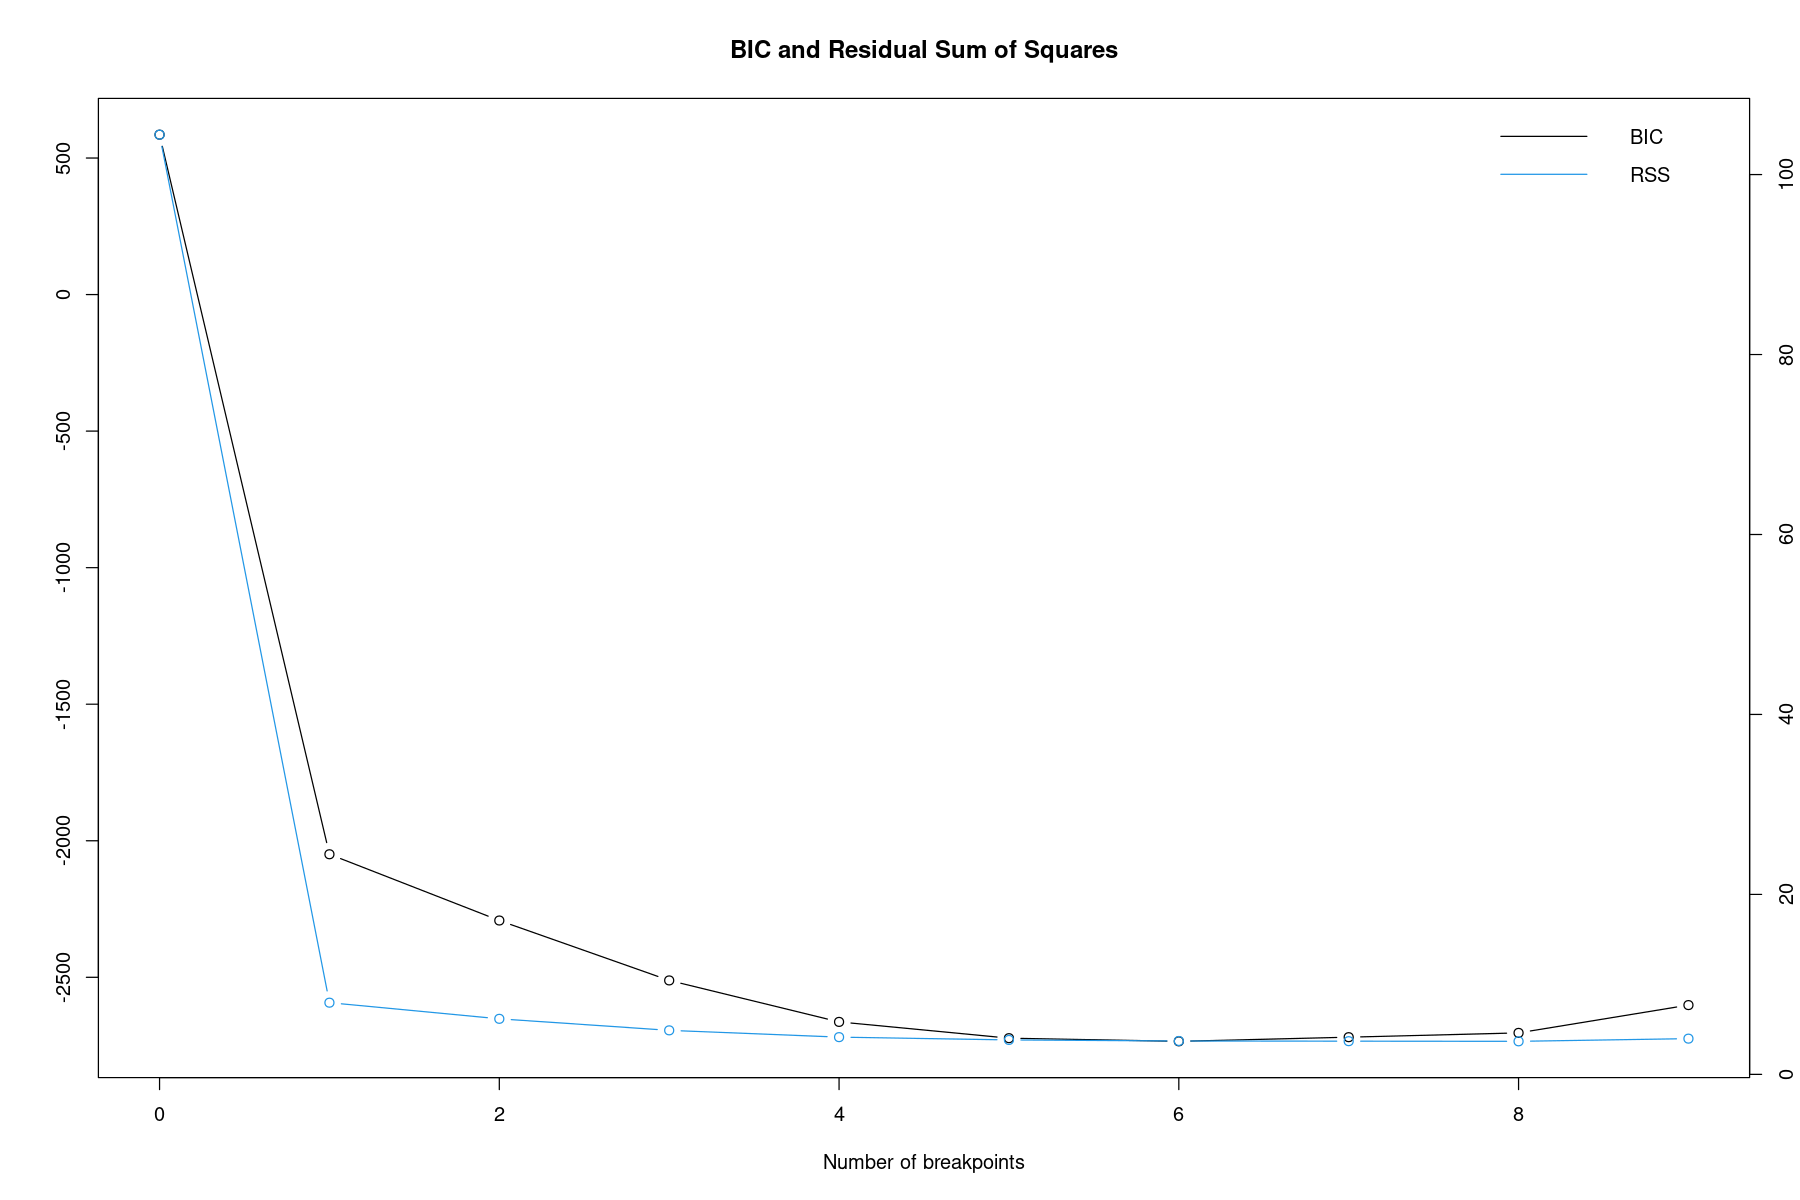

In [5]:
bp_noseas <- breakpoints(
    log_variance ~ year,
    data     = df,
    h        = .1,
    breaks   = NULL
)
par(bg = "white")
plot(bp_noseas)
print(confint(bp_noseas,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = sandwich::NeweyWest,
    level = 0.95
))

cp_df <- ordered_cp_df(bp_noseas, df)
cp_df


In [6]:
df$segment_no_seas <- breakfactor(bp_noseas)

# Fit the segmented linear model with segment-specific predictors
lmod_monthly_no_seas <- nlme::gls(
    log_variance ~ segment_no_seas +
        segment_no_seas:year - 1,
    data = df,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

# Summarize the segmented model results
summary(lmod_monthly_no_seas)


Generalized least squares fit by REML
  Model: log_variance ~ segment_no_seas + segment_no_seas:year - 1 
  Data: df 
        AIC       BIC   logLik
  -3807.577 -3699.214 1925.789

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.7680369 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6  segment7 
1.0000000 0.5210895 0.4158183 0.3844578 0.3495666 0.3524821 0.3981470 

Coefficients:
                                 Value Std.Error    t-value p-value
segment_no_seassegment1      286.50393 23.260469  12.317204  0.0000
segment_no_seassegment2      119.14534 11.218426  10.620504  0.0000
segment_no_seassegment3       28.89460  2.693310  10.728286  0.0000
segment_no_seassegment4       16.79008  3.022168   5.555640  0.0000
segment_no_seassegment5       57.84717  6.432753   8.992600  0.0000
segment_no_seas

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


pdf 
  2

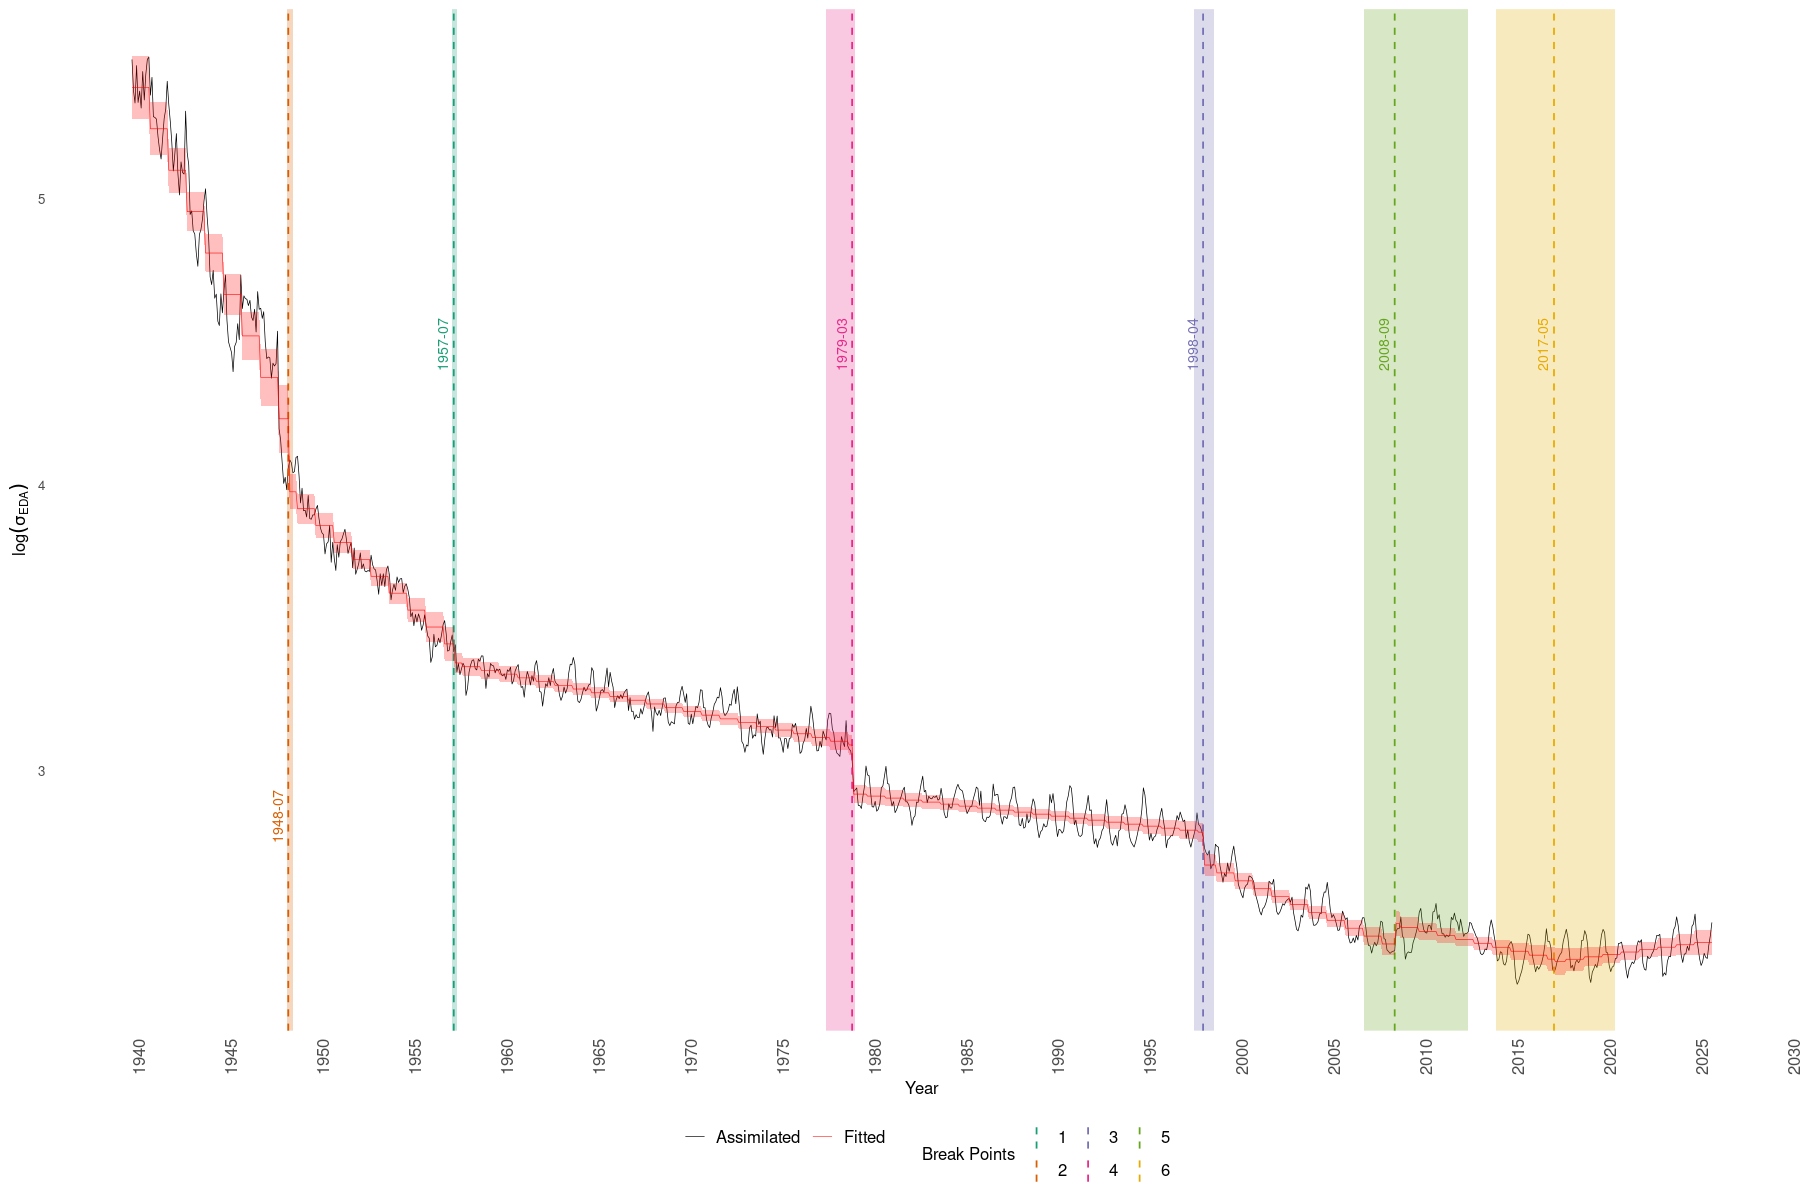

In [7]:
p <- plot_change_points(
    data = df,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE,
    title = NULL
)

fitted_layers <- add_fitted_line_ci(lmod_monthly_no_seas, df)
for (layer in fitted_layers) {
    p <- p + layer
}
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
)
p
save_plot(p, "ChangePointsNoSeasLarge.pdf", width = 7, height = 4)


In [8]:
seasonal_model <- nlme::gls(
    log_variance ~ year:segment_no_seas + segment_no_seas +
        sin_mon + cos_mon - 1,
    data = df,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

summary(seasonal_model)


Generalized least squares fit by REML
  Model: log_variance ~ year:segment_no_seas + segment_no_seas + sin_mon +      cos_mon - 1 
  Data: df 
        AIC       BIC   logLik
  -4092.429 -3974.262 2070.215

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.6846503 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6  segment7 
1.0000000 0.5669749 0.4084682 0.3166014 0.2988769 0.2999843 0.3089238 

Coefficients:
                                 Value Std.Error    t-value p-value
segment_no_seassegment1      289.65241 17.189752  16.850295  0.0000
segment_no_seassegment2      122.75244  9.026389  13.599285  0.0000
segment_no_seassegment3       29.36347  1.880854  15.611773  0.0000
segment_no_seassegment4       18.00448  1.774326  10.147218  0.0000
segment_no_seassegment5       60.05169  4.018165  14.94505

In [9]:
trend_only_df <- df %>%
    mutate(
        sin_mon = 0,
        cos_mon = 0
    )

df <- df %>%
    mutate(
        fitted_trend_only = predict(seasonal_model, newdata = trend_only_df)
    )

# The “deseasonalized” response is
#    y_i^(ds) = log_variance_i - fitted_trend_i
df <- df %>%
    mutate(
        y_seas = log_variance - fitted_trend_only
    )

# ── 4) Extract the seasonal‐term coefficients + 2×2 covariance ───────────────────
coefs_all <- coef(seasonal_model)
beta_sin <- coefs_all["sin_mon"]
beta_cos <- coefs_all["cos_mon"]

V_all <- vcov(seasonal_model)
V_seas <- V_all[c("sin_mon", "cos_mon"), c("sin_mon", "cos_mon")]

df_resid <- nrow(df) - length(coef(seasonal_model))

# ── 5) Build a 12‐row data.frame giving month = 1…12, sin_mon, cos_mon ─────────
new_season <- tibble(
    month = 1:12
) %>%
    mutate(
        sin_mon = sin(2 * pi * (month / 12)),
        cos_mon = cos(2 * pi * (month / 12))
    ) %>%
    rowwise() %>%
    mutate(
        # point‐estimate of the seasonal fit
        fit = beta_sin * sin_mon + beta_cos * cos_mon,
        fitsin = beta_sin * sin_mon,
        fitcos = beta_cos * cos_mon,

        # its standard error:  sqrt([s c] %*% V_seas %*% [s; c])
        se = sqrt(
            c(sin_mon, cos_mon) %*% V_seas %*% matrix(c(sin_mon, cos_mon), ncol = 1)
        )
    ) %>%
    ungroup() %>%
    mutate(
        lwr = fit - qt(0.975, df = df_resid) * se,
        upr = fit + qt(0.975, df = df_resid) * se
    )


pdf 
  2

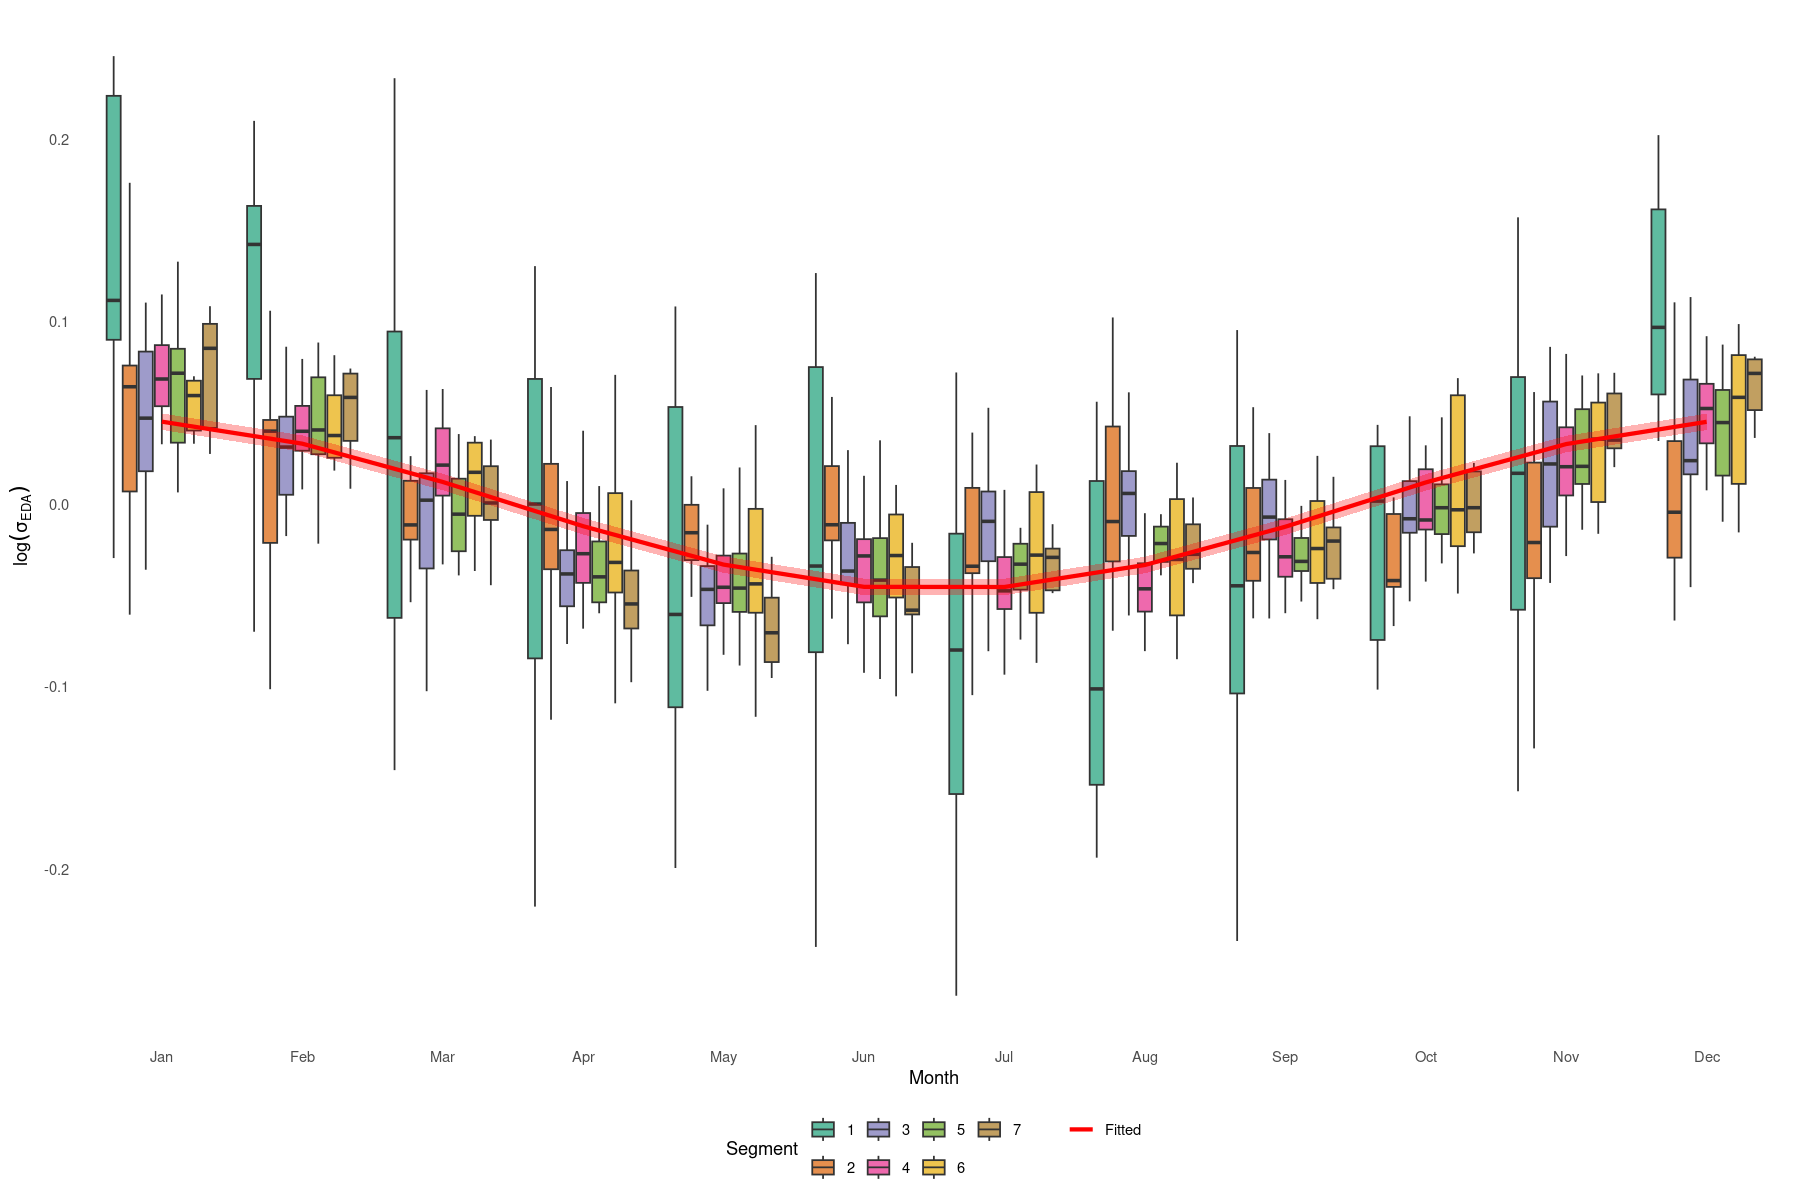

In [10]:
p <- ggplot(df, aes(x = factor(month), fill = segment_no_seas)) +
    # Box plots for residuals by month and segment
    geom_boxplot(aes(y = y_seas),
        alpha = 0.7,
        outlier.shape = NA, # Remove outliers
        width = 0.7,
        position = position_dodge(width = 0.8)
    ) +
    # Adjust fill legend to show only numbers
    scale_fill_brewer(
        type = "qual",
        palette = "Dark2",
        name = "Segment",
        labels = function(x) gsub("segment", "", x) # strip "segment"
    ) +
    geom_ribbon(
        data = new_season,
        aes(x = month, ymin = lwr, ymax = upr, group = 1),
        alpha = 0.3,
        fill = "red",
        inherit.aes = FALSE,
        show.legend = FALSE
    ) +
    # Add seasonal trend line WITH legend
    geom_line(
        data = new_season,
        aes(x = month, y = fit, group = 1, color = "Fitted"),
        size = 1.2,
        linetype = "solid",
        inherit.aes = FALSE
    ) +
    scale_color_manual(
        name = "",
        values = c("Fitted" = "red")
    ) +
    scale_x_discrete(labels = month.abb) +
    labs(
        x = "Month",
        y = TeX("$\\log(\\sigma_{EDA})$")
    ) +
    theme_minimal() +
    theme(
        panel.grid = element_blank(),
        legend.position = "bottom"
    ) +
    guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 2)
    )

# Display the plot
print(p)
save_plot(p, "MonthlyResSingleSeason.pdf", width = 7, height = 5)


**The above shows that it is crucial to allow the seasonal cycle to vary between segments! See also the last section in this notebook**

## Multiple structural change models (Bai & Perron, 2003)
**Challenge:** Choose either max number of breakpoints or minimum segment size?

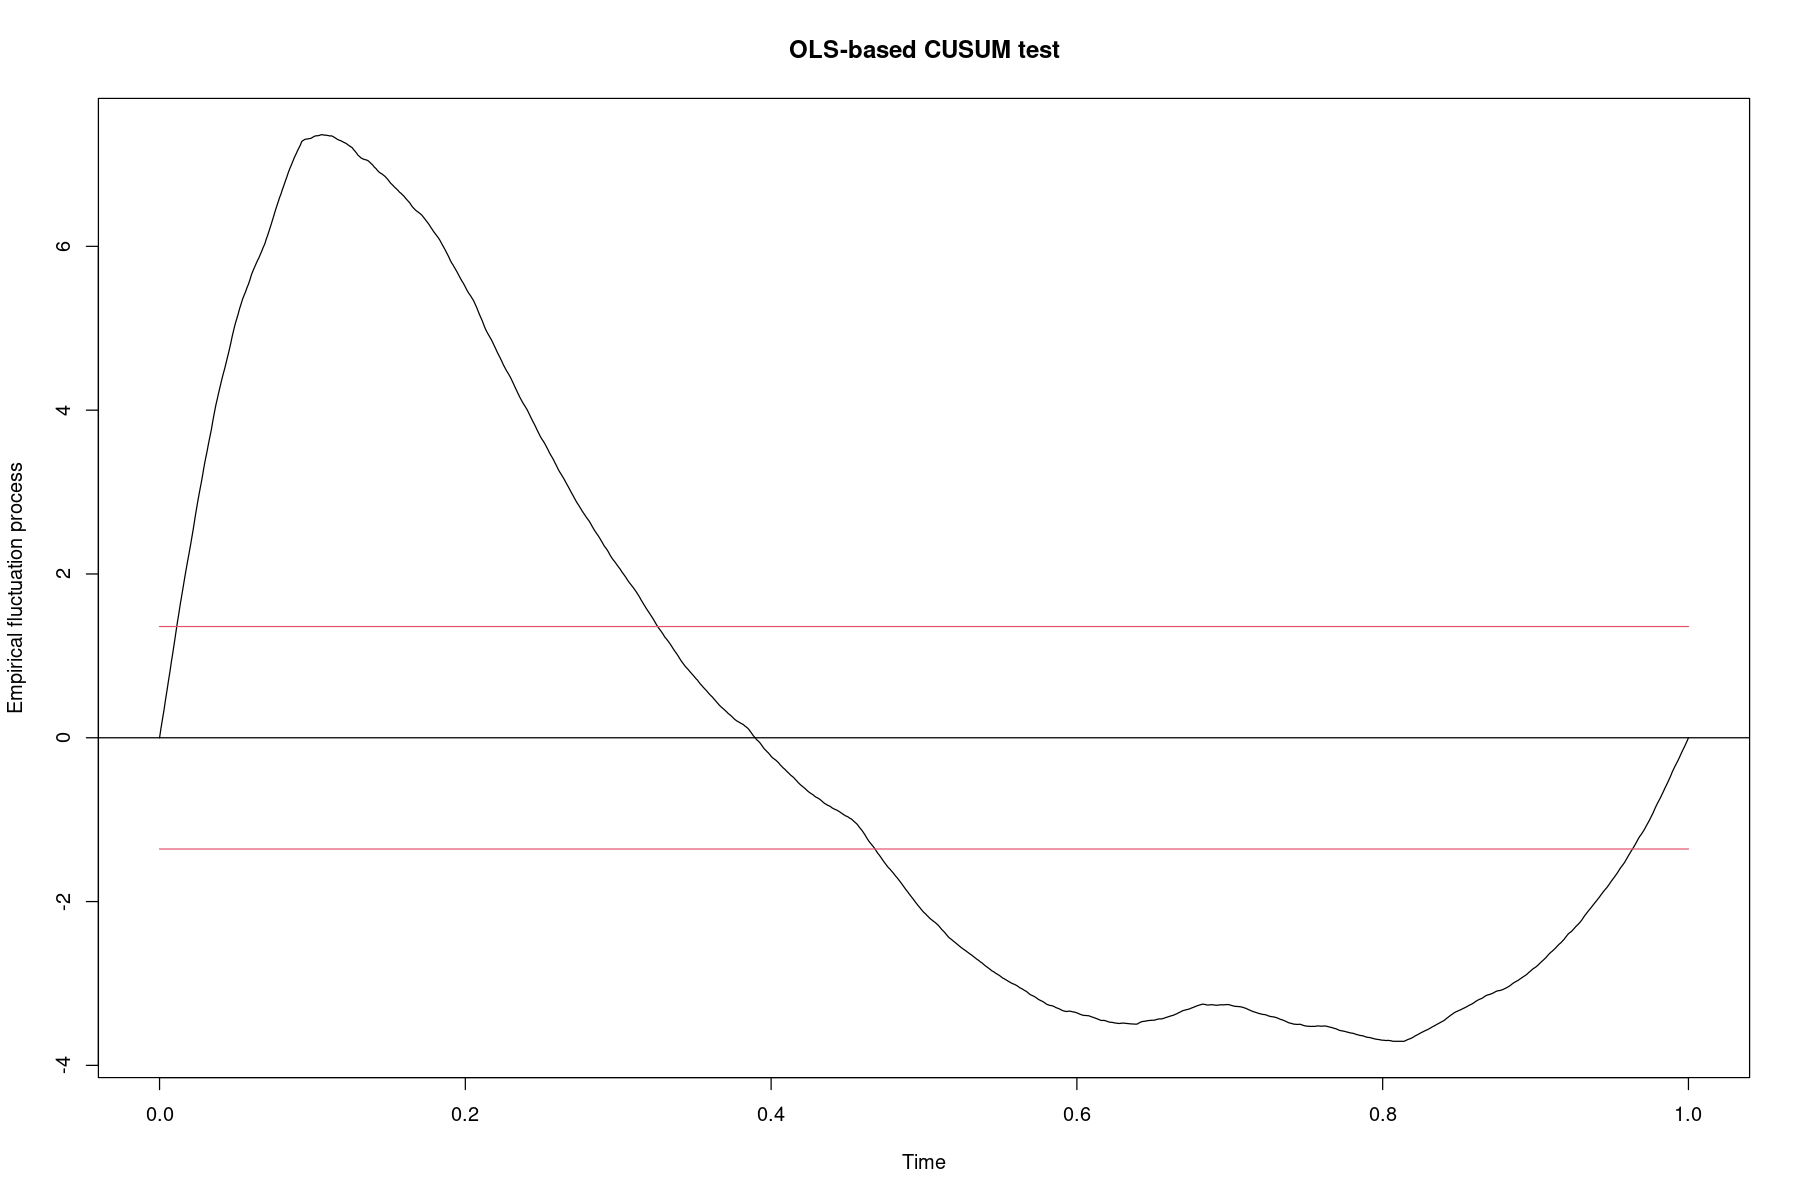

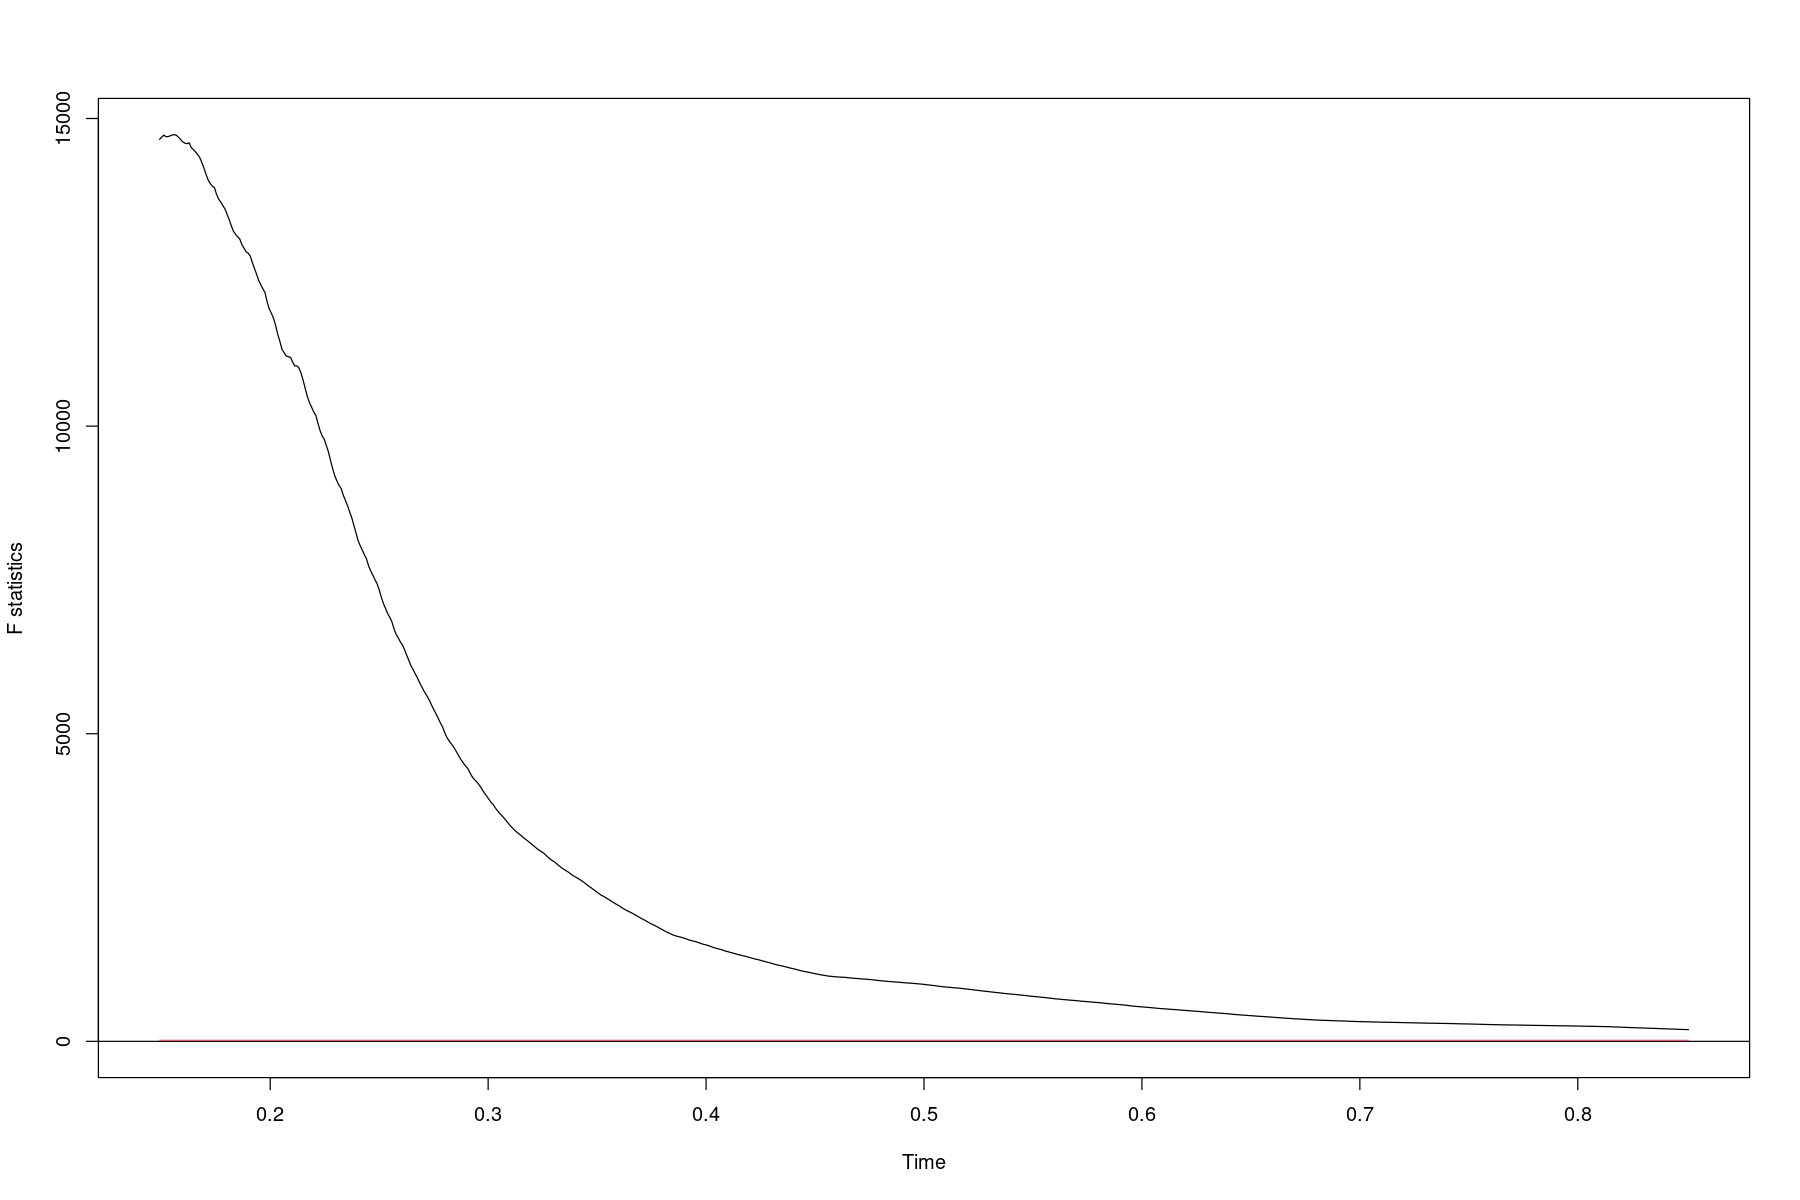

In [11]:
par(bg = "white")

ocus <- efp(
    formula = log_variance ~ year + sin_mon + cos_mon,
    data = df,
    type = "OLS-CUSUM"
)

plot(ocus)

fs <- Fstats(log_variance ~ year + sin_mon + cos_mon, data = df)
plot(fs)


pdf 
  2


	 Optimal 7-segment partition: 

Call:
breakpoints.formula(formula = log_variance ~ year + sin_mon + 
    cos_mon, h = 0.1, breaks = NULL, data = df)

Breakpoints at observation number:
105 212 471 704 826 929 

Corresponding to breakdates:
0.1017442 0.2054264 0.4563953 0.6821705 0.8003876 0.9001938 

	 Confidence intervals for breakpoints
	 of optimal 7-segment partition: 

Call:
confint.breakpointsfull(object = bp_est_monthly, level = 0.95, 
    het.reg = TRUE, het.err = TRUE, vcov. = sandwich::NeweyWest, 
    sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   104         105    107
2   211         212    214
3   469         471    472
4   703         704    706
5   820         826    835
6   927         929    951

Corresponding to breakdates:
      2.5 % breakpoints    97.5 %
1 0.1007752   0.1017442 0.1036822
2 0.2044574   0.2054264 0.2073643
3 0.4544574   0.4563953 0.4573643
4 0.6812016   0.6821705 0.6841085
5 0.7945736   0.8003876 0.8091085
6 0.8

,cp_date,cp_date_lower,cp_date_upper,ci_width_obs,cp_no
,<date>,<date>,<date>,<dbl>,<int>
1,1948-09-01,1948-08-01,1948-11-01,3,1
2,1957-08-01,1957-07-01,1957-10-01,3,2
3,1979-03-01,1979-01-01,1979-04-01,3,3
4,1998-08-01,1998-07-01,1998-10-01,3,4
5,2008-10-01,2008-04-01,2009-07-01,15,5
6,2017-05-01,2017-03-01,2019-03-01,24,6


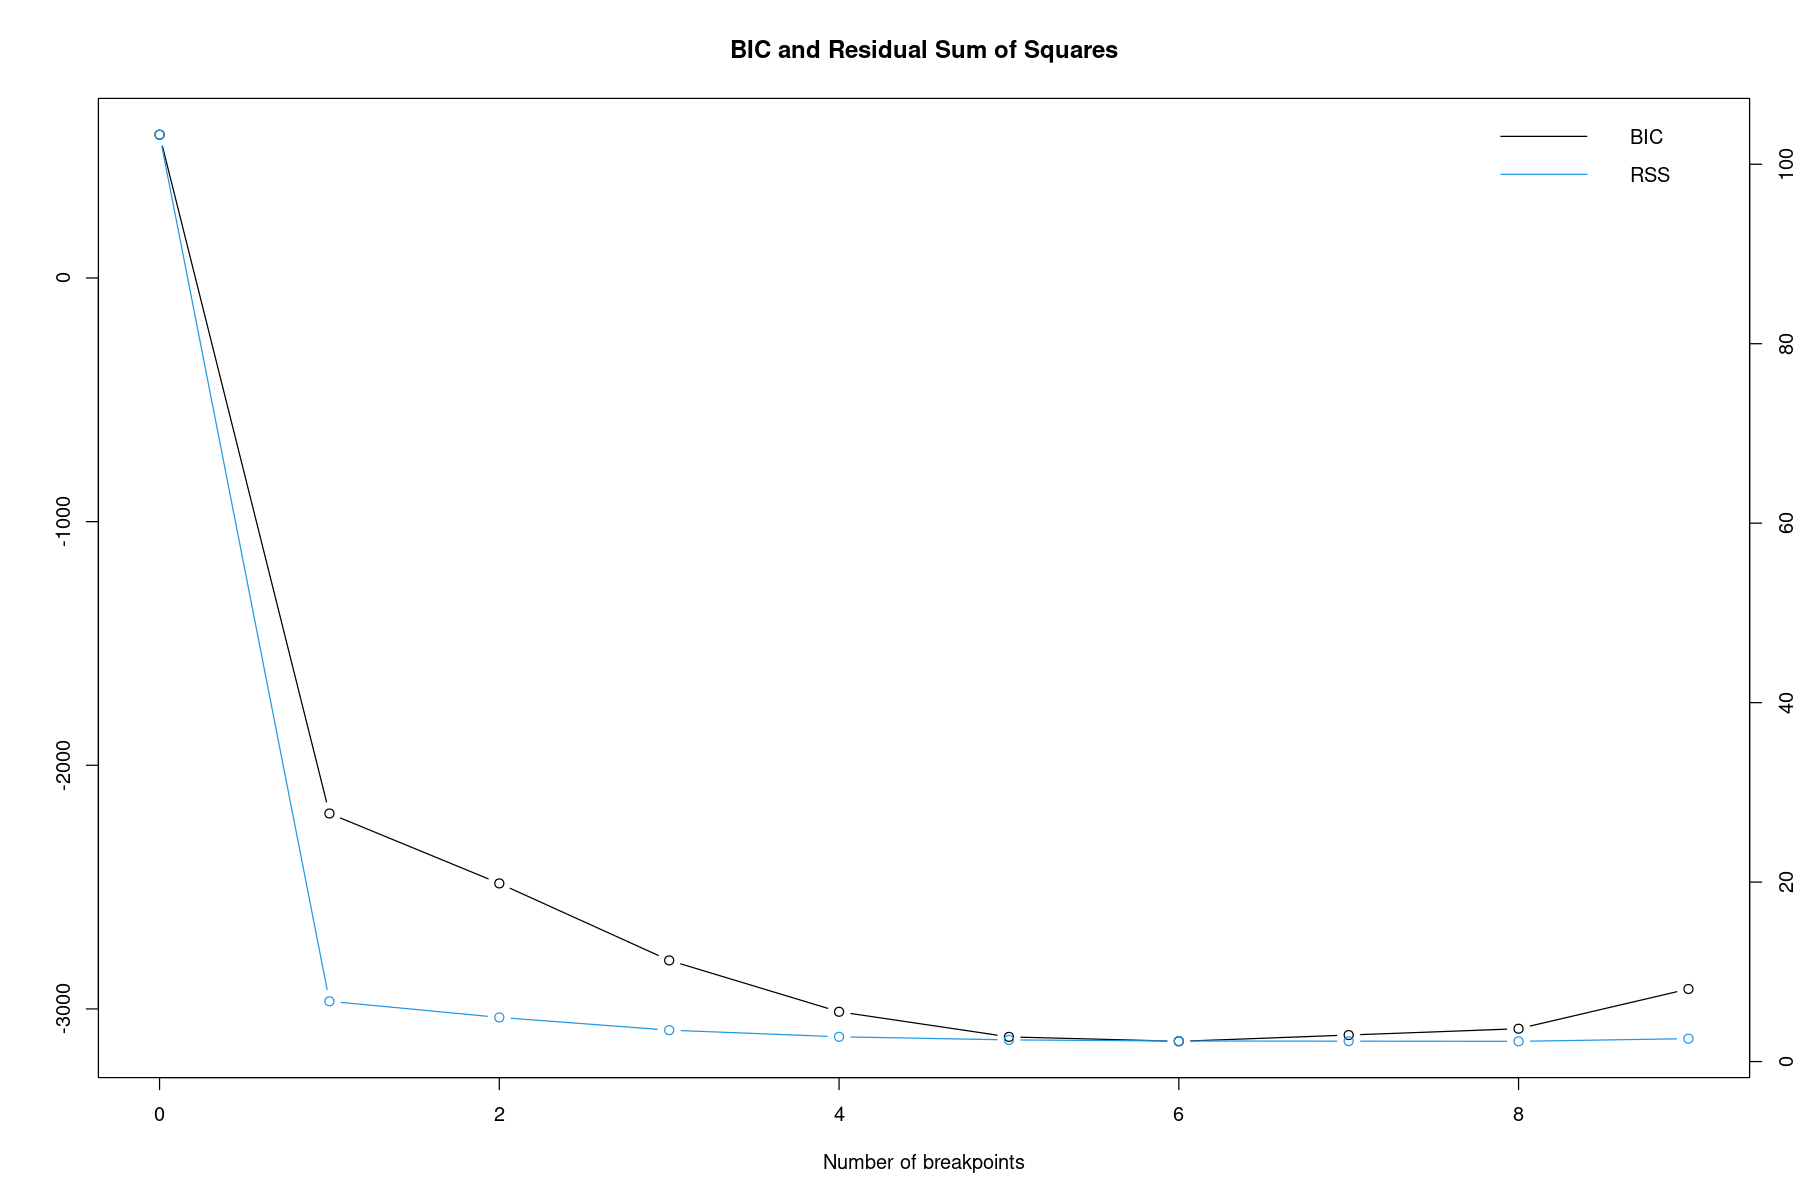

In [12]:
# Estimate breakpoints with seasonal predictors differing in each segment
# Control for AR(1)
bp_est_monthly <- breakpoints(log_variance ~ year + sin_mon + cos_mon,
    data = df,
    h = .1,
    breaks = NULL
)

par(bg = "white")
plot(bp_est_monthly)
pdf(paste0(OUT_DIR, "BIC_breakpoints.pdf"), width = 4, height = 3)
plot(bp_est_monthly)
dev.off()
print(bp_est_monthly)
print(confint(bp_est_monthly,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = sandwich::NeweyWest,
    level = 0.95
))
cp_df <- ordered_cp_df(bp_est_monthly, df)
cp_df


In [13]:
df$segment <- breakfactor(bp_est_monthly)

# Fit the segmented linear model with segment-specific predictors
lmod_seas_monthly <- nlme::gls(
    log_variance ~ segment +
        segment:year + segment:sin_mon + segment:cos_mon - 1,
    data = df,
    correlation = corAR1(form = ~ mon_no | segment),
    weights = varIdent(form = ~ 1 | segment)
)

# Summarize the segmented model results
summary(lmod_seas_monthly)


Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_mon + segment:cos_mon -      1 
  Data: df 
        AIC      BIC   logLik
  -4047.643 -3870.82 2059.821

Correlation Structure: AR(1)
 Formula: ~mon_no | segment 
 Parameter estimate(s):
      Phi 
0.6588957 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6  segment7 
1.0000000 0.5519940 0.4023015 0.3188130 0.2929226 0.3163650 0.3097804 

Coefficients:
                            Value Std.Error    t-value p-value
segmentsegment1         294.23966 15.306816  19.222786  0.0000
segmentsegment2         121.15537  8.195505  14.783148  0.0000
segmentsegment3          28.34217  1.682284  16.847438  0.0000
segmentsegment4          18.64344  1.571753  11.861557  0.0000
segmentsegment5          54.73834  3.707347  14.764826  0.0000
segmentsegment6          29.73470  5.1

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message:
“Using size for a discrete variable is not advised.”


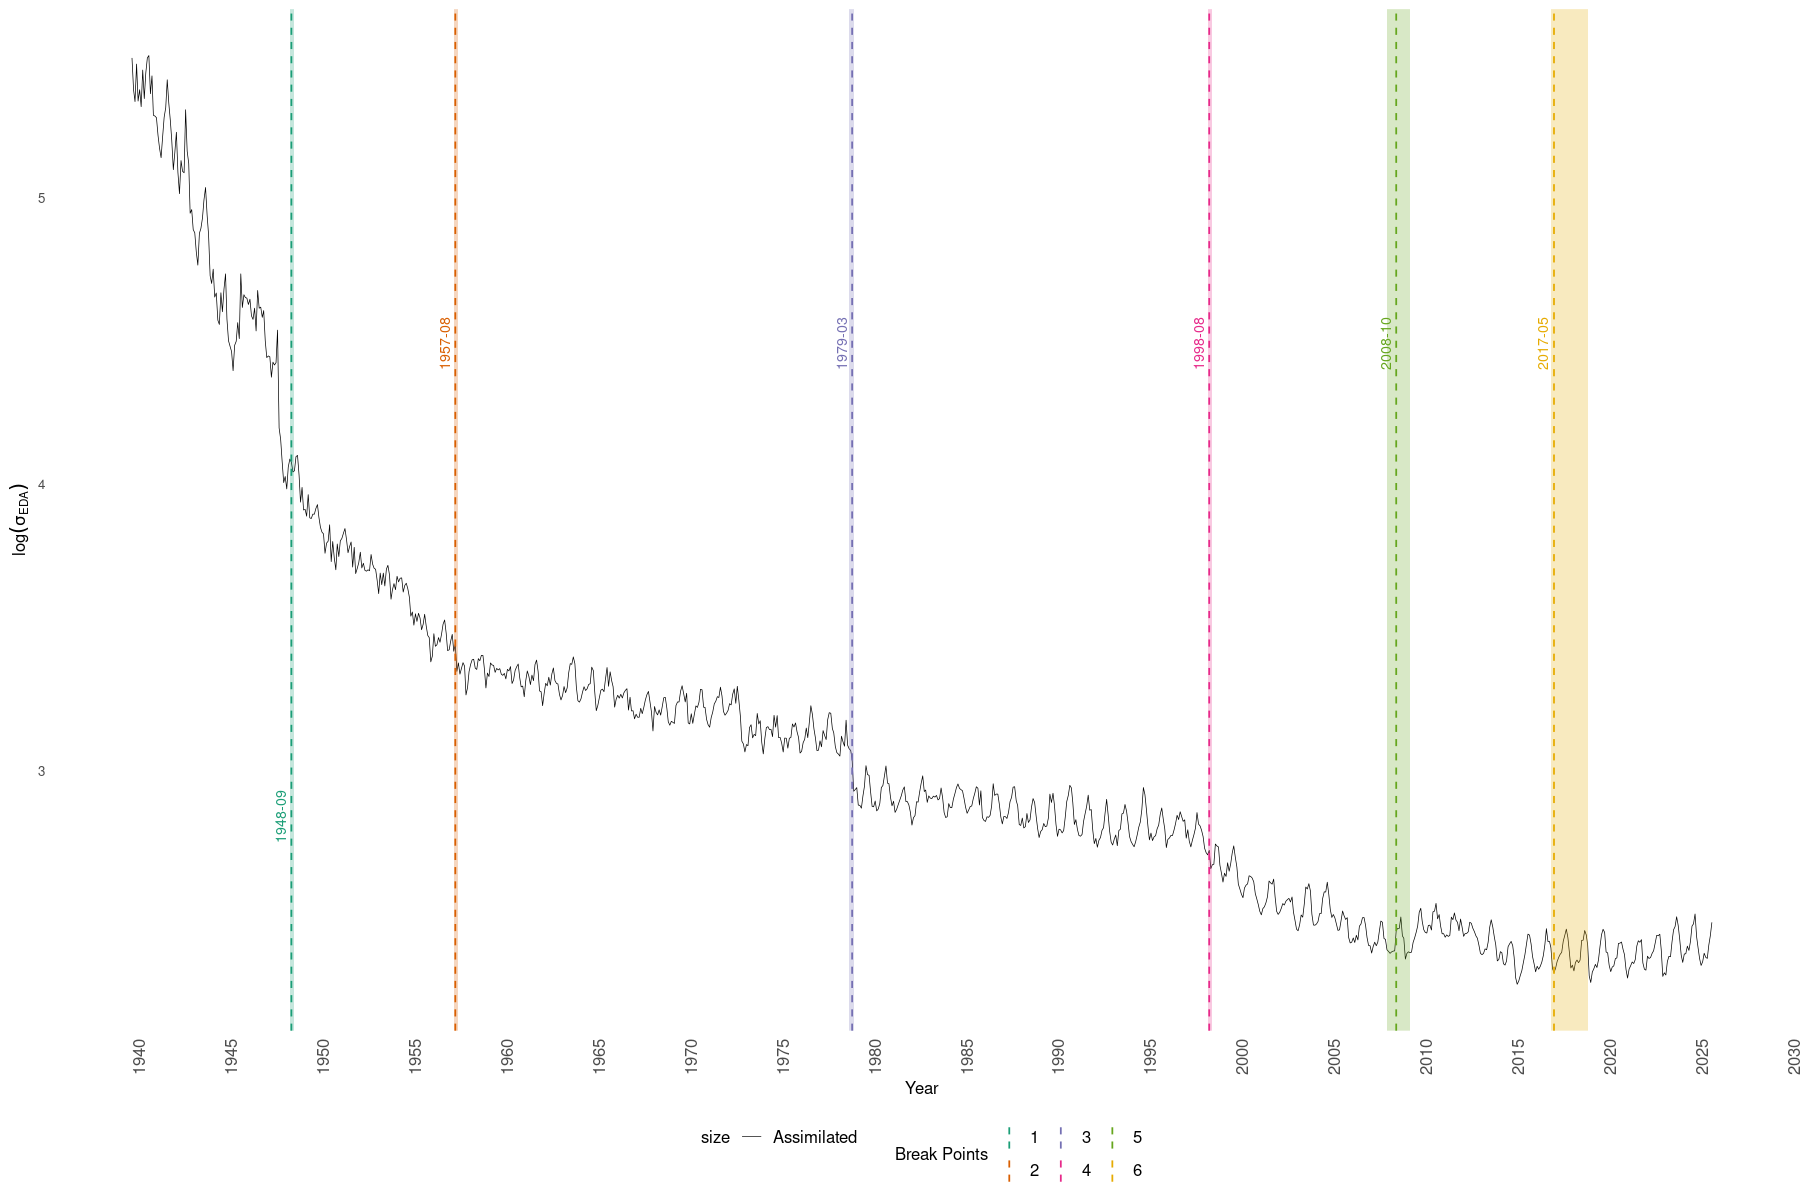

pdf 
  2

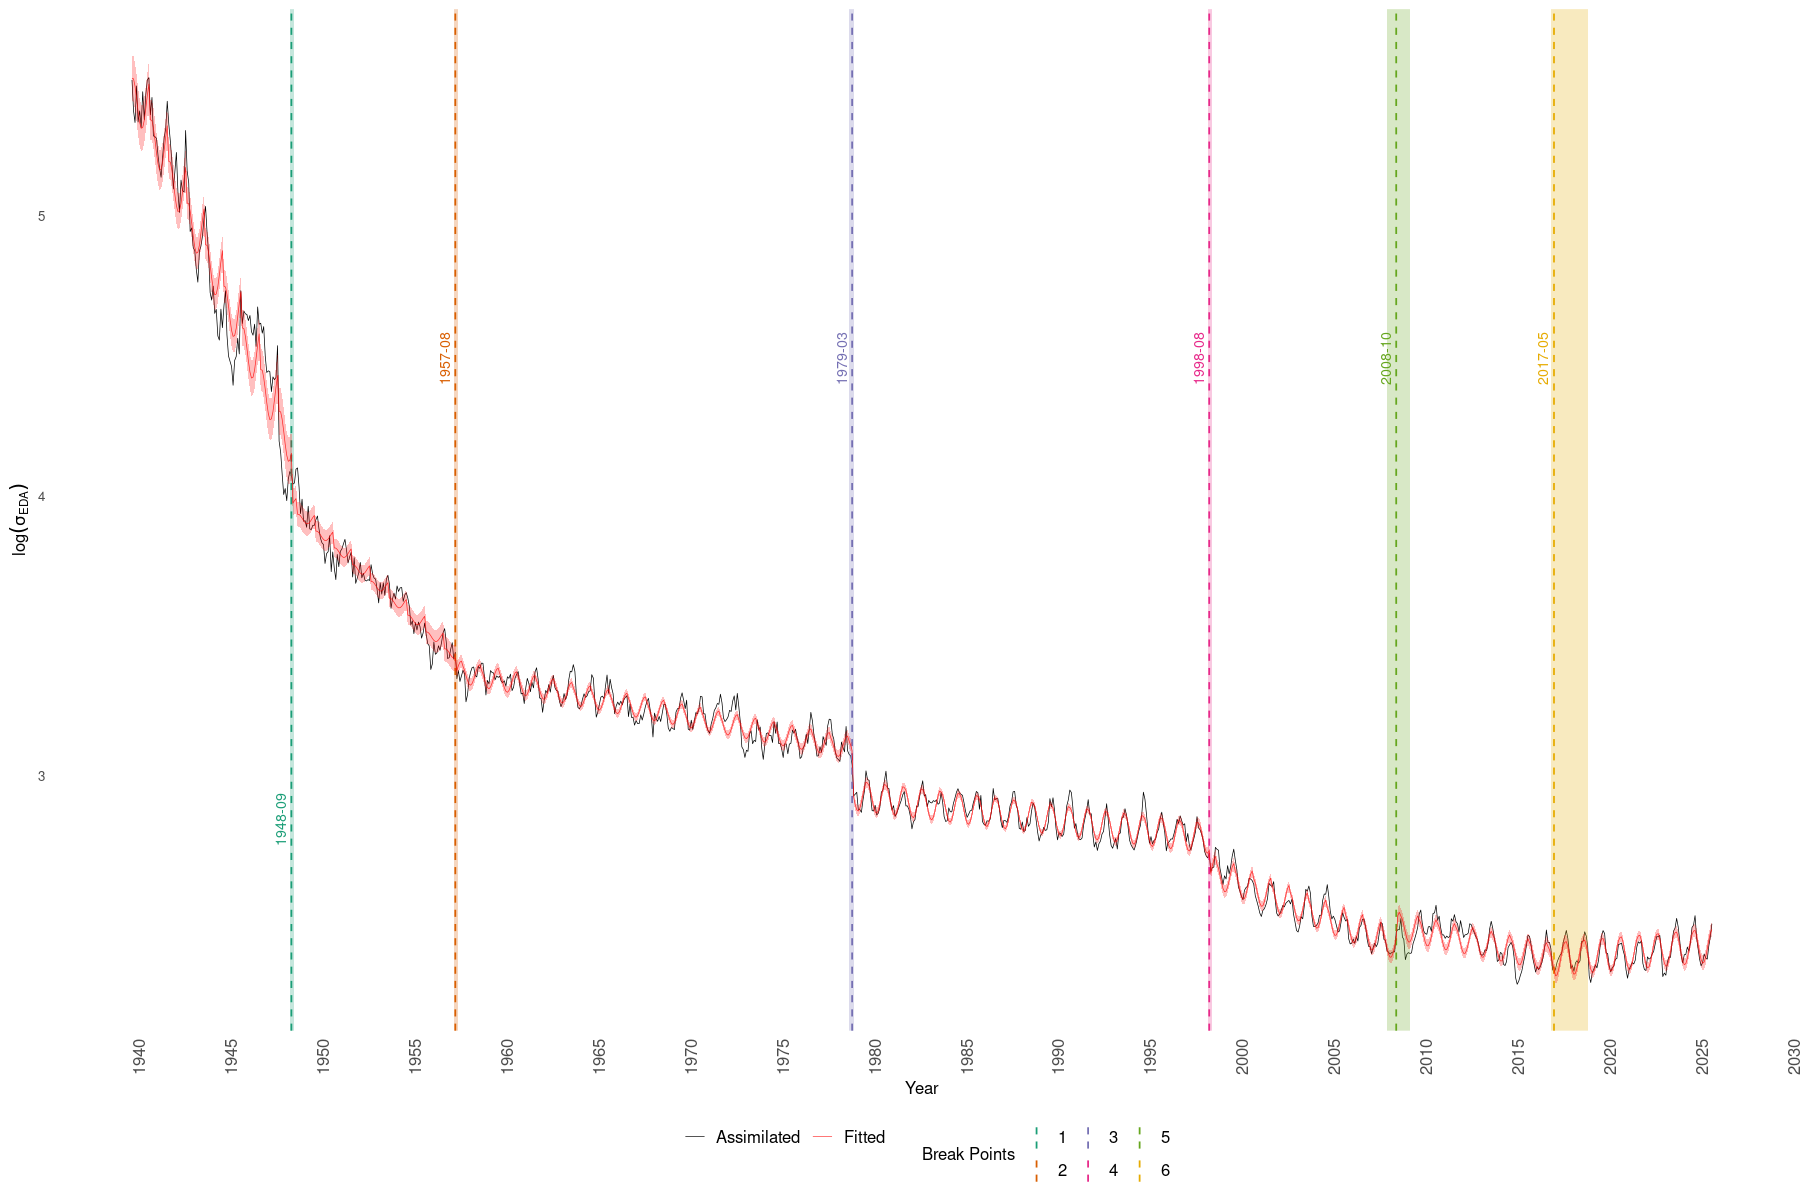

pdf 
  2

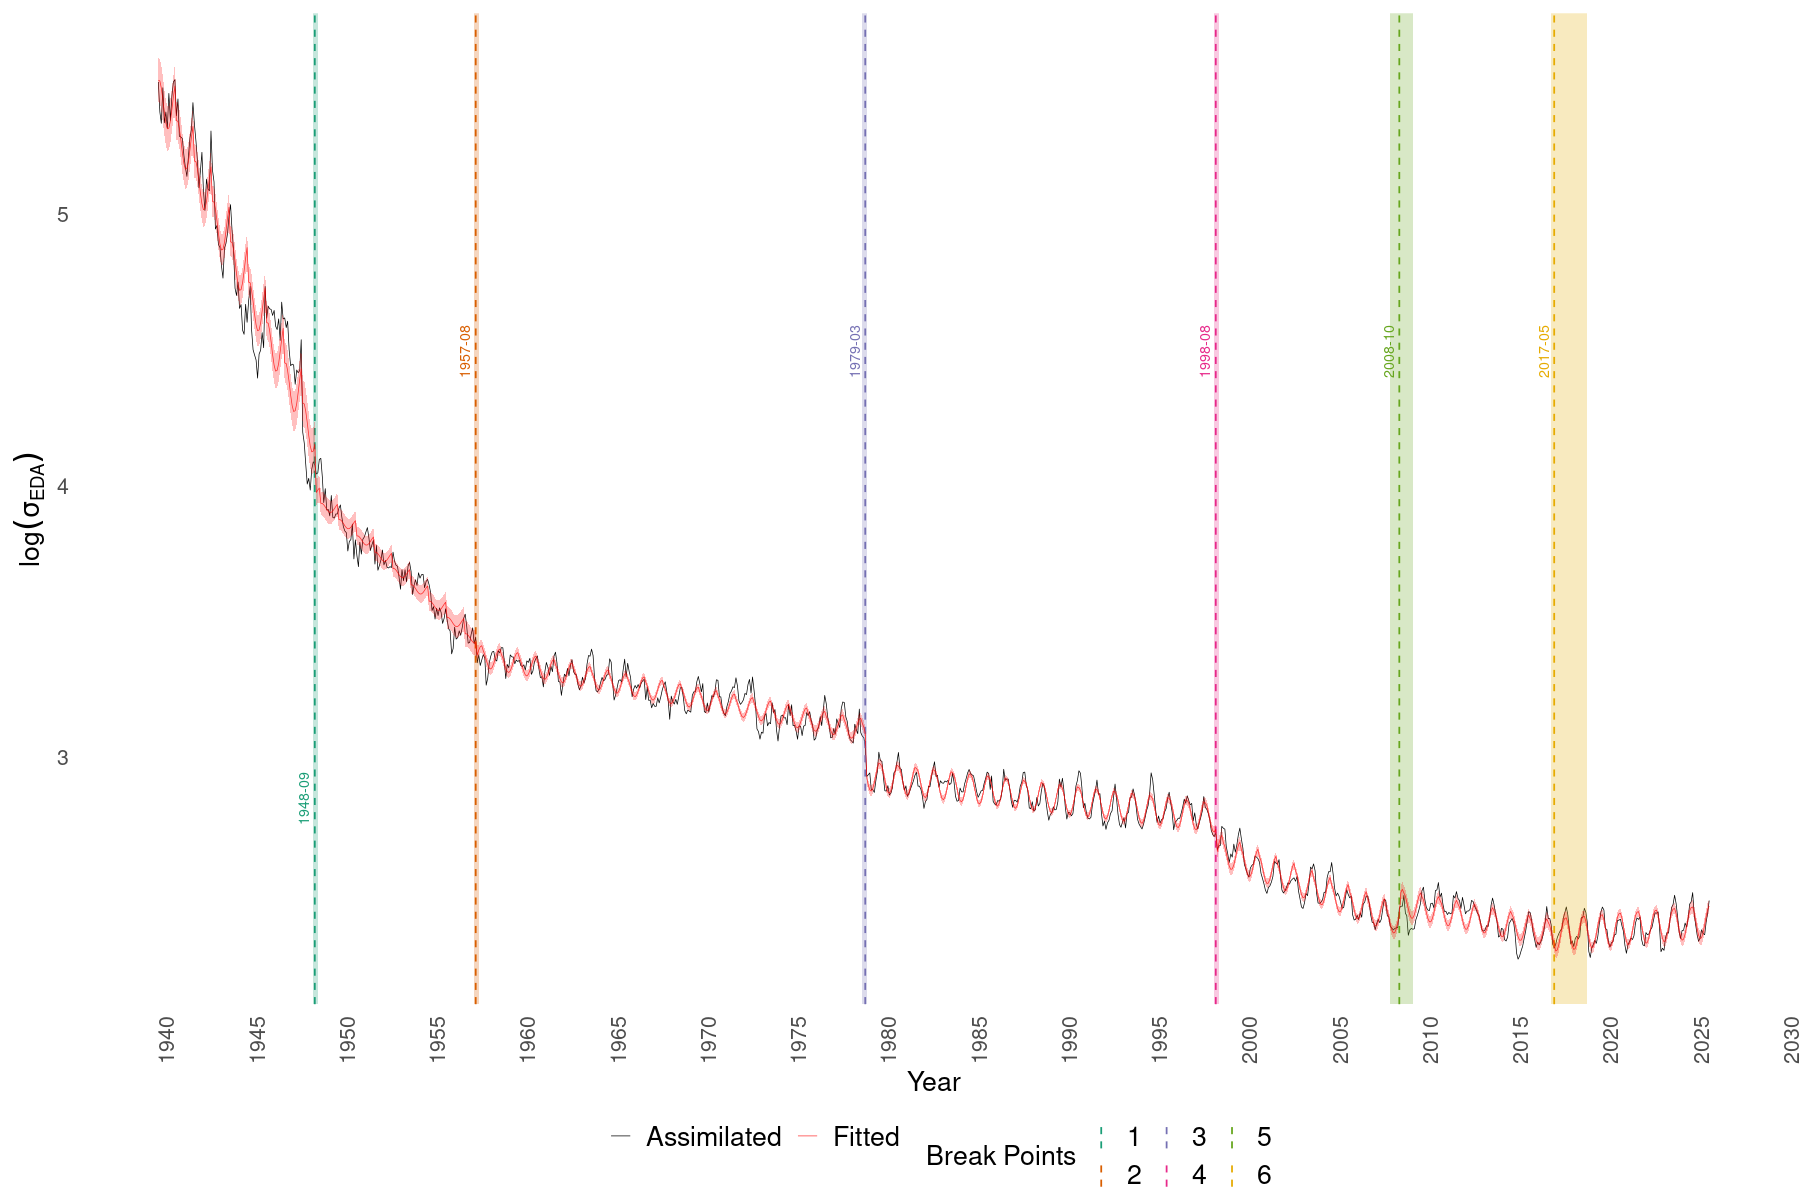

In [14]:
p <- plot_change_points(
    data = df,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE,
    title = NULL
)
p

fitted_layers <- add_fitted_line_ci(lmod_seas_monthly, df)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
) #+ THEME_PUB

p

save_plot(p, "ChangePoints.pdf", width = 7, height = 4)

p <- p + THEME_PUB_LARGE
p
save_plot(p, "ChangePointsLarge.pdf", width = 9.5, height = 4.25)


### Is the assumption of a constant ar coefficient justified?


In [14]:
library(nlme)

# 1) Refit the restricted model (common phi) using ML
fit_restr <- update(lmod_seas_monthly, method = "ML")

# 2) Fit separate ML models for each segment (each gets its own phi)
segments <- unique(df$segment) # ensure this matches how segment was defined
fits_per_segment <- lapply(segments, function(s) {
    gls(log_variance ~ year + sin_mon + cos_mon,
        data = subset(df, segment == s),
        correlation = corAR1(form = ~mon_no), # per-segment AR(1)
        weights = NULL, # varIdent not needed inside single-segment fits
        method = "ML"
    )
})

# 3) Compute log-likelihoods and LR statistic
ll_restr <- as.numeric(logLik(fit_restr))
ll_unrest <- sum(sapply(fits_per_segment, function(x) as.numeric(logLik(x))))
LR <- 2 * (ll_unrest - ll_restr)
df_diff <- length(segments) - 1
p_value <- pchisq(LR, df = df_diff, lower.tail = FALSE)

# 4) Report
list(
    LR = LR, df = df_diff, p.value = p_value,
    ll_restricted = ll_restr, ll_unrestricted = ll_unrest
)

# Restricted (common phi)
phi_restr <- coef(fit_restr$modelStruct$corStruct, unconstrained = FALSE)

# Per-segment phis
phi_unrest <- sapply(fits_per_segment, function(m) {
    coef(m$modelStruct$corStruct, unconstrained = FALSE)
})

phi_comparison <- data.frame(
    segment = segments,
    phi_unrestricted = phi_unrest,
    phi_restricted = phi_restr
)
phi_comparison


$LR
[1] 25.91623

$df
[1] 5

$p.value
[1] 9.263666e-05

$ll_restricted
[1] 2142.61

$ll_unrestricted
[1] 2155.568

Warning message in data.frame(segment = segments, phi_unrestricted = phi_unrest, :
“Zeilennamen wurden in einer short Variablen gefunden und wurden verworfen”


segment,phi_unrestricted,phi_restricted
<fct>,<dbl>,<dbl>
segment1,0.7343459,0.6649444
segment2,0.5504188,0.6649444
segment3,0.5543565,0.6649444
segment4,0.5282980,0.6649444
segment5,0.6888922,0.6649444
segment6,0.8154581,0.6649444


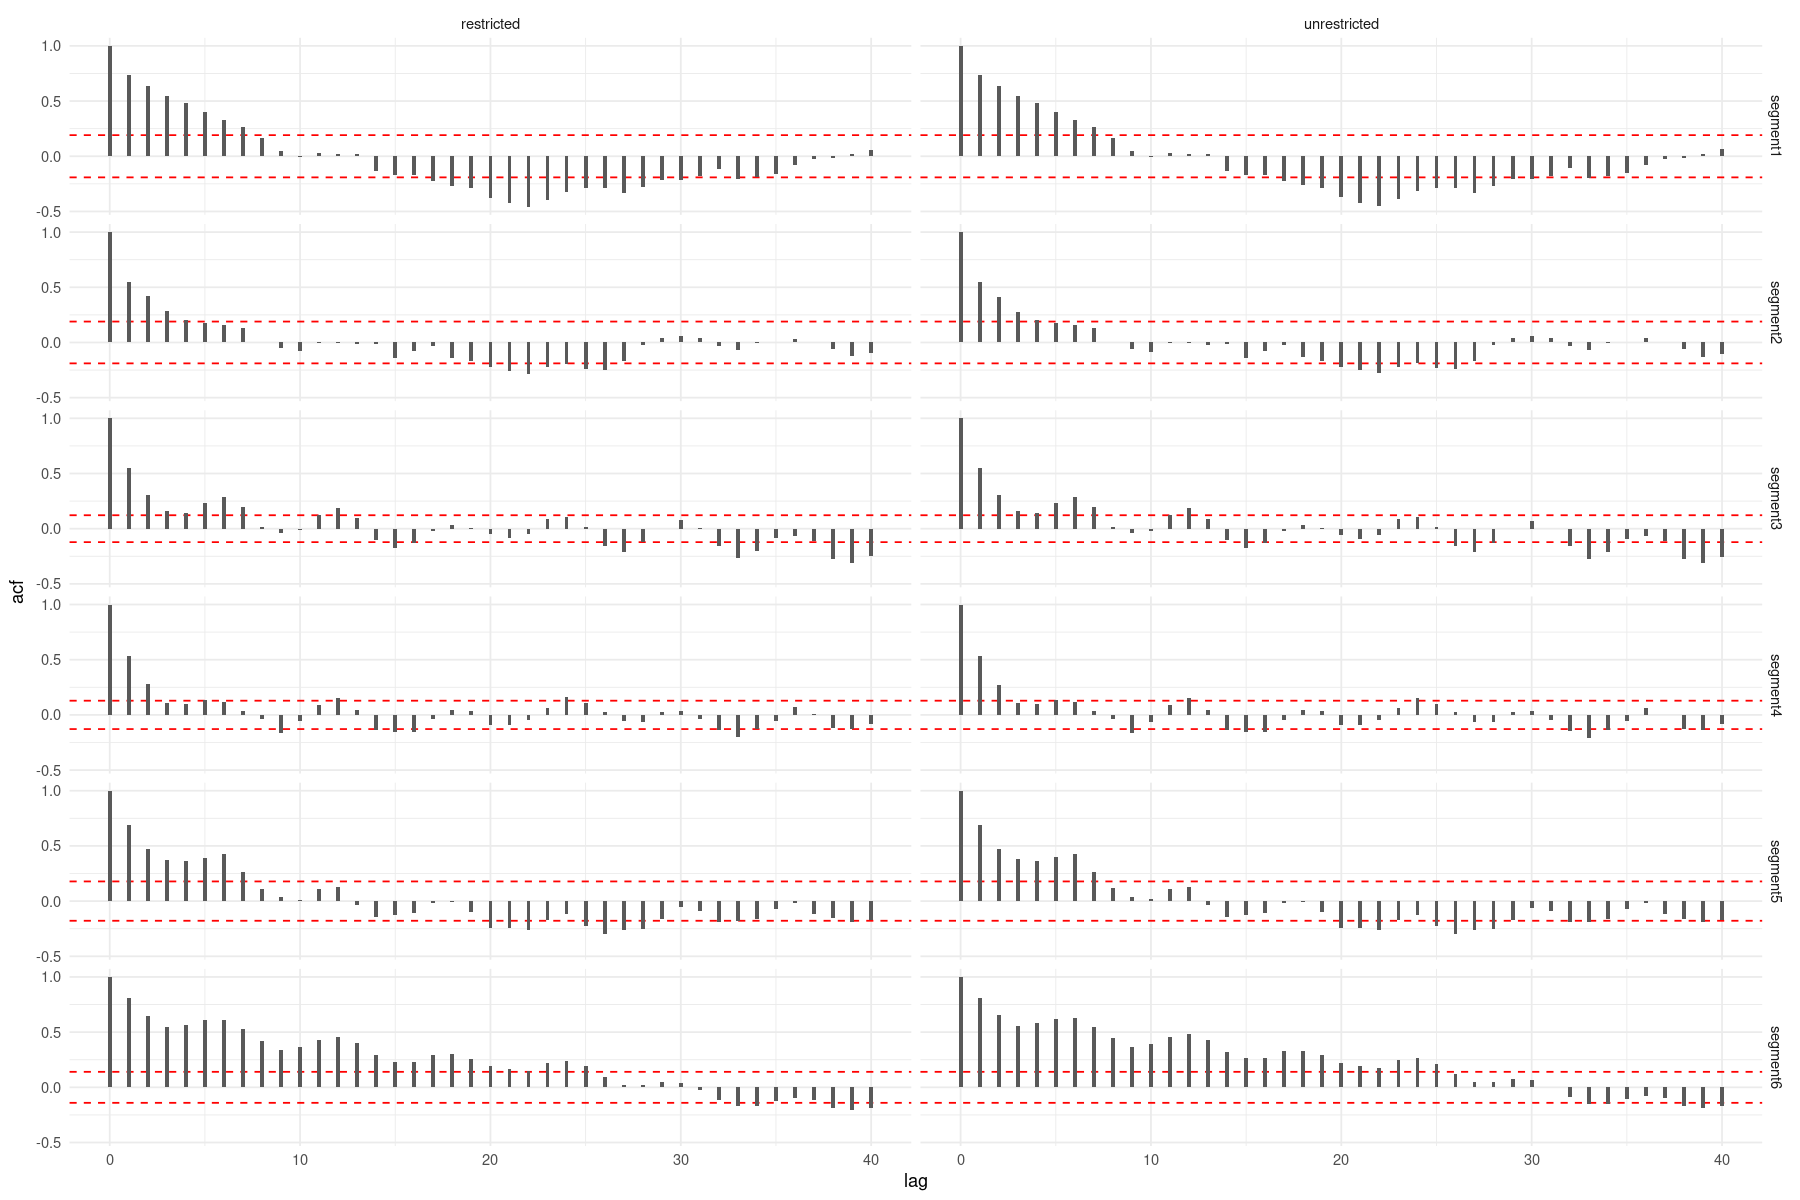

In [24]:
library(ggplot2)

acf_df <- function(x, segment, model, lag.max = 40) {
    x <- na.omit(x)
    if (length(x) == 0) {
        return(NULL)
    }
    ac <- acf(x, plot = FALSE, lag.max = lag.max)
    data.frame(
        lag     = ac$lag[, 1, 1],
        acf     = ac$acf[, 1, 1],
        n       = length(x),
        segment = segment,
        model   = model
    )
}

acf_data <- do.call(rbind, lapply(segments, function(s) {
    idx <- df$segment == s
    res_restr <- resid(fit_restr)[idx]
    res_unrest <- resid(fits_per_segment[[s]])
    rbind(
        acf_df(res_restr, s, "restricted"),
        acf_df(res_unrest, s, "unrestricted")
    )
}))

# add bounds: ±1.96/sqrt(n) per row
acf_data$bound <- with(acf_data, 1.96 / sqrt(n))

ggplot(acf_data, aes(x = lag, y = acf)) +
    geom_hline(aes(yintercept = bound), linetype = "dashed", color = "red") +
    geom_hline(aes(yintercept = -bound), linetype = "dashed", color = "red") +
    geom_bar(stat = "identity", width = 0.2) +
    facet_grid(segment ~ model) +
    theme_minimal()


In [16]:
# Extract coefficients & SEs
coef_restr <- summary(fit_restr)$tTable
coef_unrest <- lapply(fits_per_segment, function(m) summary(m)$tTable)

coef_restr
coef_unrest


,Value,Std.Error,t-value,p-value
segmentsegment1,294.065799141,1.541491e+01,19.0767106,2.143520e-69
segmentsegment2,120.963079153,8.270577e+00,14.6257118,4.998309e-44
segmentsegment3,28.322593250,1.719905e+00,16.4675303,4.525397e-54
segmentsegment4,18.621187982,1.605594e+00,11.5976960,2.917131e-29
segmentsegment5,55.637236206,3.755593e+00,14.8145019,5.047141e-45
segmentsegment6,12.178108772,2.171059e+00,5.6092945,2.631413e-08
segmentsegment1:year,-0.148794460,7.929929e-03,-18.7636570,1.692771e-67
segmentsegment2:year,-0.060054244,4.235432e-03,-14.1790120,1.052509e-41
segmentsegment3:year,-0.012749041,8.739491e-04,-14.5878522,7.898359e-44
segmentsegment4:year,-0.007930314,8.074534e-04,-9.8213889,8.562511e-22


,Value,Std.Error,t-value,p-value
(Intercept),291.19378423,18.783922011,15.502289,1.847717e-28
year,-0.14731730,0.009663041,-15.245439,6.055864e-28
sin_mon,0.06068380,0.019766446,3.070041,2.749308e-03
cos_mon,0.06805999,0.019763728,3.443682,8.367072e-04
,Value,Std.Error,t-value,p-value
(Intercept),123.42247201,6.372470488,19.368073,4.082096e-36
year,-0.06131404,0.003263397,-18.788407,4.710675e-35
sin_mon,0.01198373,0.009432817,1.270430,2.067938e-01
cos_mon,0.01286478,0.009511694,1.352523,1.791701e-01
,Value,Std.Error,t-value,p-value


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Blue = unrestricted φ with bootstrap CI; Red dashed = restricted φ ± bootstrap CI' in 'mbcsToSbcs': Punkt ersetzt <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Blue = unrestricted φ with bootstrap CI; Red dashed = restricted φ ± bootstrap CI' in 'mbcsToSbcs': Punkt ersetzt <86>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konvertierungsfehler für 'Blue = unrestricted φ with bootstrap CI; Red dashed = restricted φ ± bootstrap CI' in 'mbcsToSbcs': Punkt ersetzt <cf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Konverti

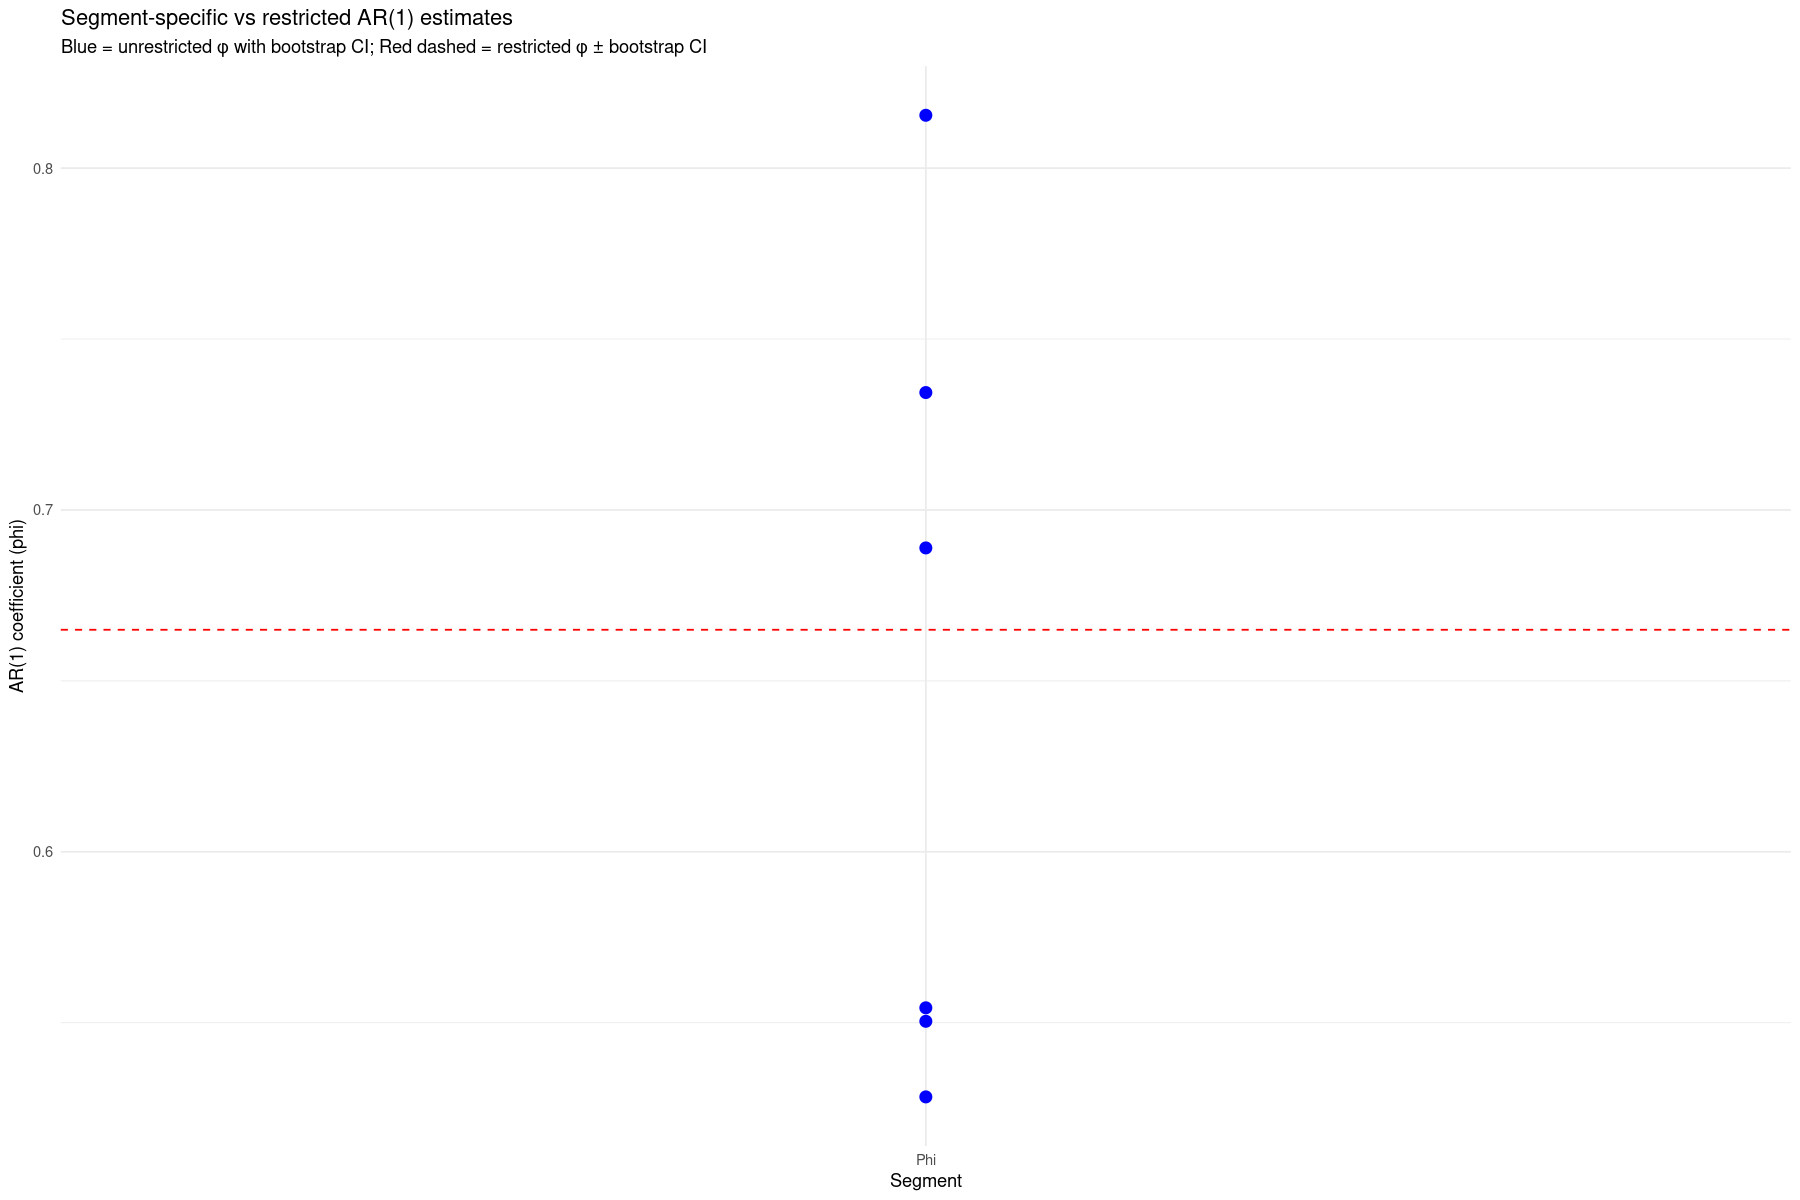

In [31]:
library(nlme)
library(dplyr)
library(ggplot2)

boot_phi_resid <- function(fit, response = "log_variance", B = 200) {
    phis <- numeric(B)
    res <- resid(fit, type = "normalized") # normalized residuals
    fitted_vals <- fitted(fit)

    for (b in seq_len(B)) {
        # Resample residuals with replacement
        res_star <- sample(res, replace = TRUE)
        y_star <- fitted_vals + res_star

        df_star <- fit$data
        df_star[[response]] <- y_star # overwrite response

        refit <- try(update(fit, data = df_star), silent = TRUE)
        if (!inherits(refit, "try-error")) {
            phis[b] <- coef(refit$modelStruct$corStruct, unconstrained = FALSE)
        } else {
            phis[b] <- NA
        }
    }
    na.omit(phis)
}


# Example: bootstrap restricted phi
phi_restr_boot <- boot_phi_resid(fit_restr, B = 200)

# Bootstrap unrestricted phis per segment
phi_unrest_boot <- lapply(fits_per_segment, function(m) boot_phi_resid(m, B = 200))

# Collect results
phi_restr <- coef(fit_restr$modelStruct$corStruct, unconstrained = FALSE)
phi_unrest <- sapply(fits_per_segment, function(m) {
    coef(m$modelStruct$corStruct, unconstrained = FALSE)
})

phi_df <- data.frame(
    segment = names(phi_unrest),
    phi_unrest = phi_unrest,
    se_unrest = sapply(phi_unrest_boot, sd)
)
phi_df$phi_restr <- phi_restr
phi_df$se_restr <- sd(phi_restr_boot)

# Keep one row per segment
phi_plot_df <- phi_df %>%
    group_by(segment) %>%
    summarize(
        phi_unrest = first(phi_unrest),
        se_unrest  = first(se_unrest)
    ) %>%
    ungroup()

# Make segment a factor
phi_plot_df$segment <- factor(phi_plot_df$segment, levels = unique(phi_plot_df$segment))


# Make segment a factor
# Keep one row per segment
phi_plot_df <- phi_df %>%
    group_by(segment) %>%
    summarize(
        phi_unrest = first(phi_unrest),
        se_unrest  = first(se_unrest)
    ) %>%
    ungroup()

# Make segment a factor
phi_plot_df$segment <- factor(phi_plot_df$segment, levels = unique(phi_plot_df$segment))


ggplot(phi_df, aes(x = segment, y = phi_unrest)) +
    geom_point(color = "blue", size = 3) +
    geom_errorbar(
        aes(
            ymin = phi_unrest - 1.96 * se_unrest,
            ymax = phi_unrest + 1.96 * se_unrest
        ),
        width = 0.2, color = "blue"
    ) +
    geom_hline(yintercept = phi_restr, linetype = "dashed", color = "red") +
    geom_hline(
        yintercept = phi_restr + 1.96 * phi_df$se_restr[1],
        linetype = "dotted", color = "red"
    ) +
    geom_hline(
        yintercept = phi_restr - 1.96 * phi_df$se_restr[1],
        linetype = "dotted", color = "red"
    ) +
    theme_minimal() +
    labs(
        y = "AR(1) coefficient (phi)",
        x = "Segment",
        title = "Segment-specific vs restricted AR(1) estimates",
        subtitle = "Blue = unrestricted φ with bootstrap CI; Red dashed = restricted φ ± bootstrap CI"
    )


no

### Have a look at the seasonal cycles for each segment and for the whole period
- We want uncertainties for amplitude and phase. 
- We want to use a parametric bootstrap for this (draw parameters from the betas according to their mean and covariance estimates)
- This is only ok if the residuals are approximately normally distributed, do we need to check

Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 

	Shapiro-Wilk normality test

data:  std_resid
W = 0.99886, p-value = 0.7824



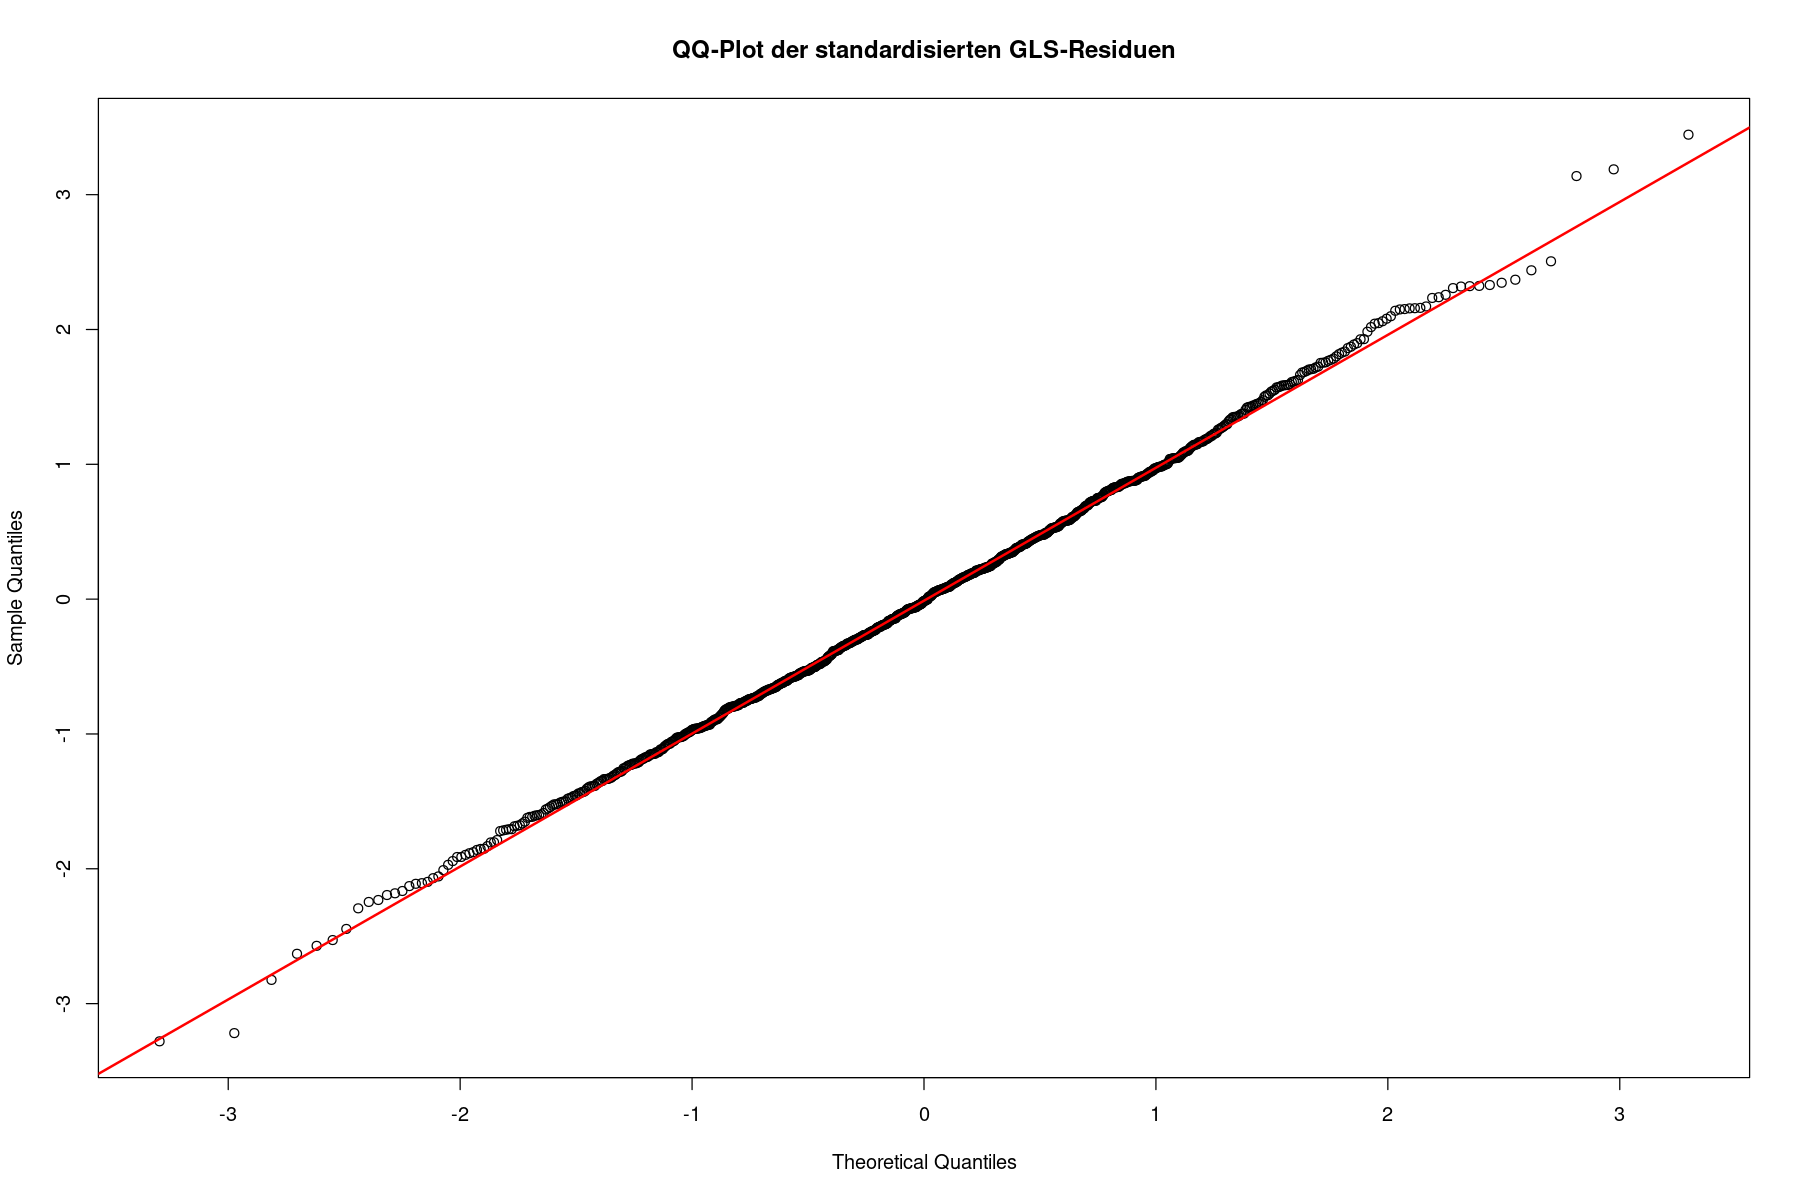

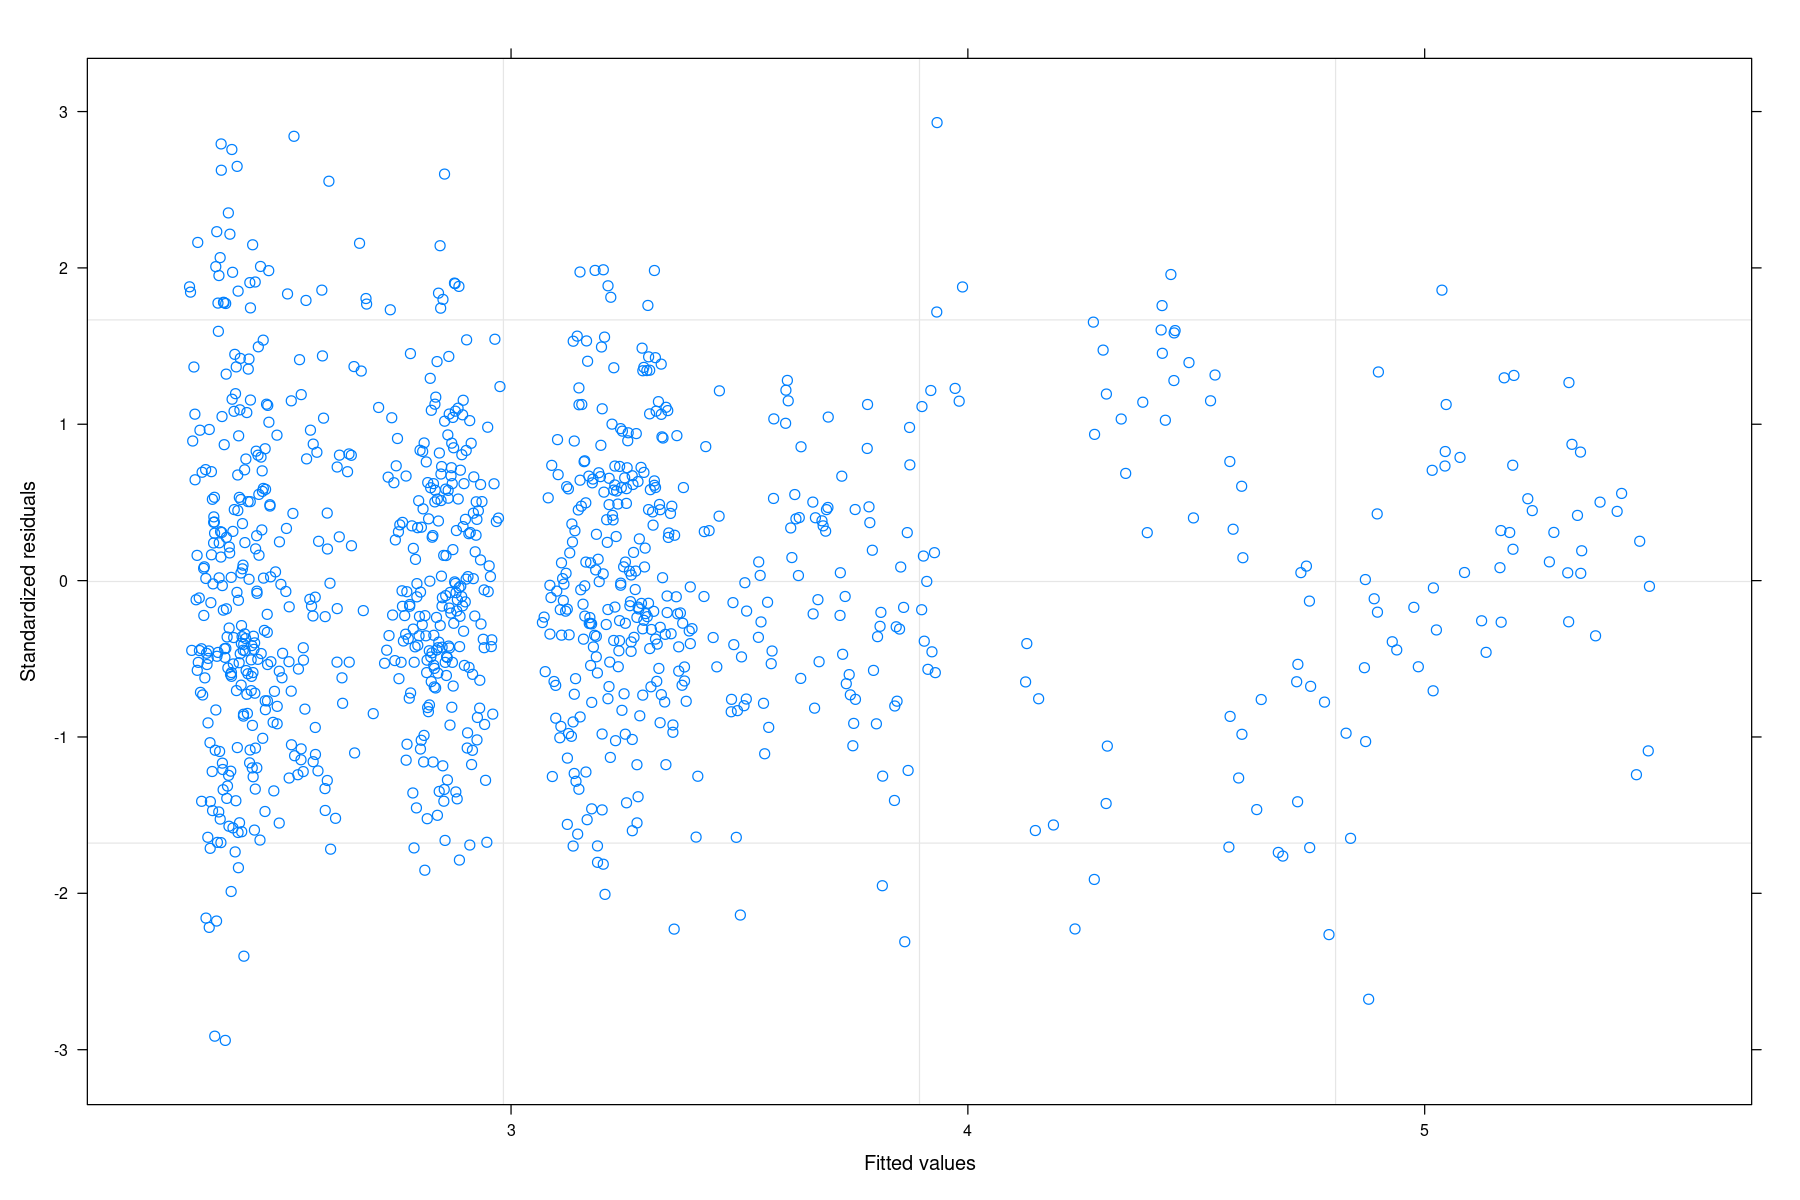

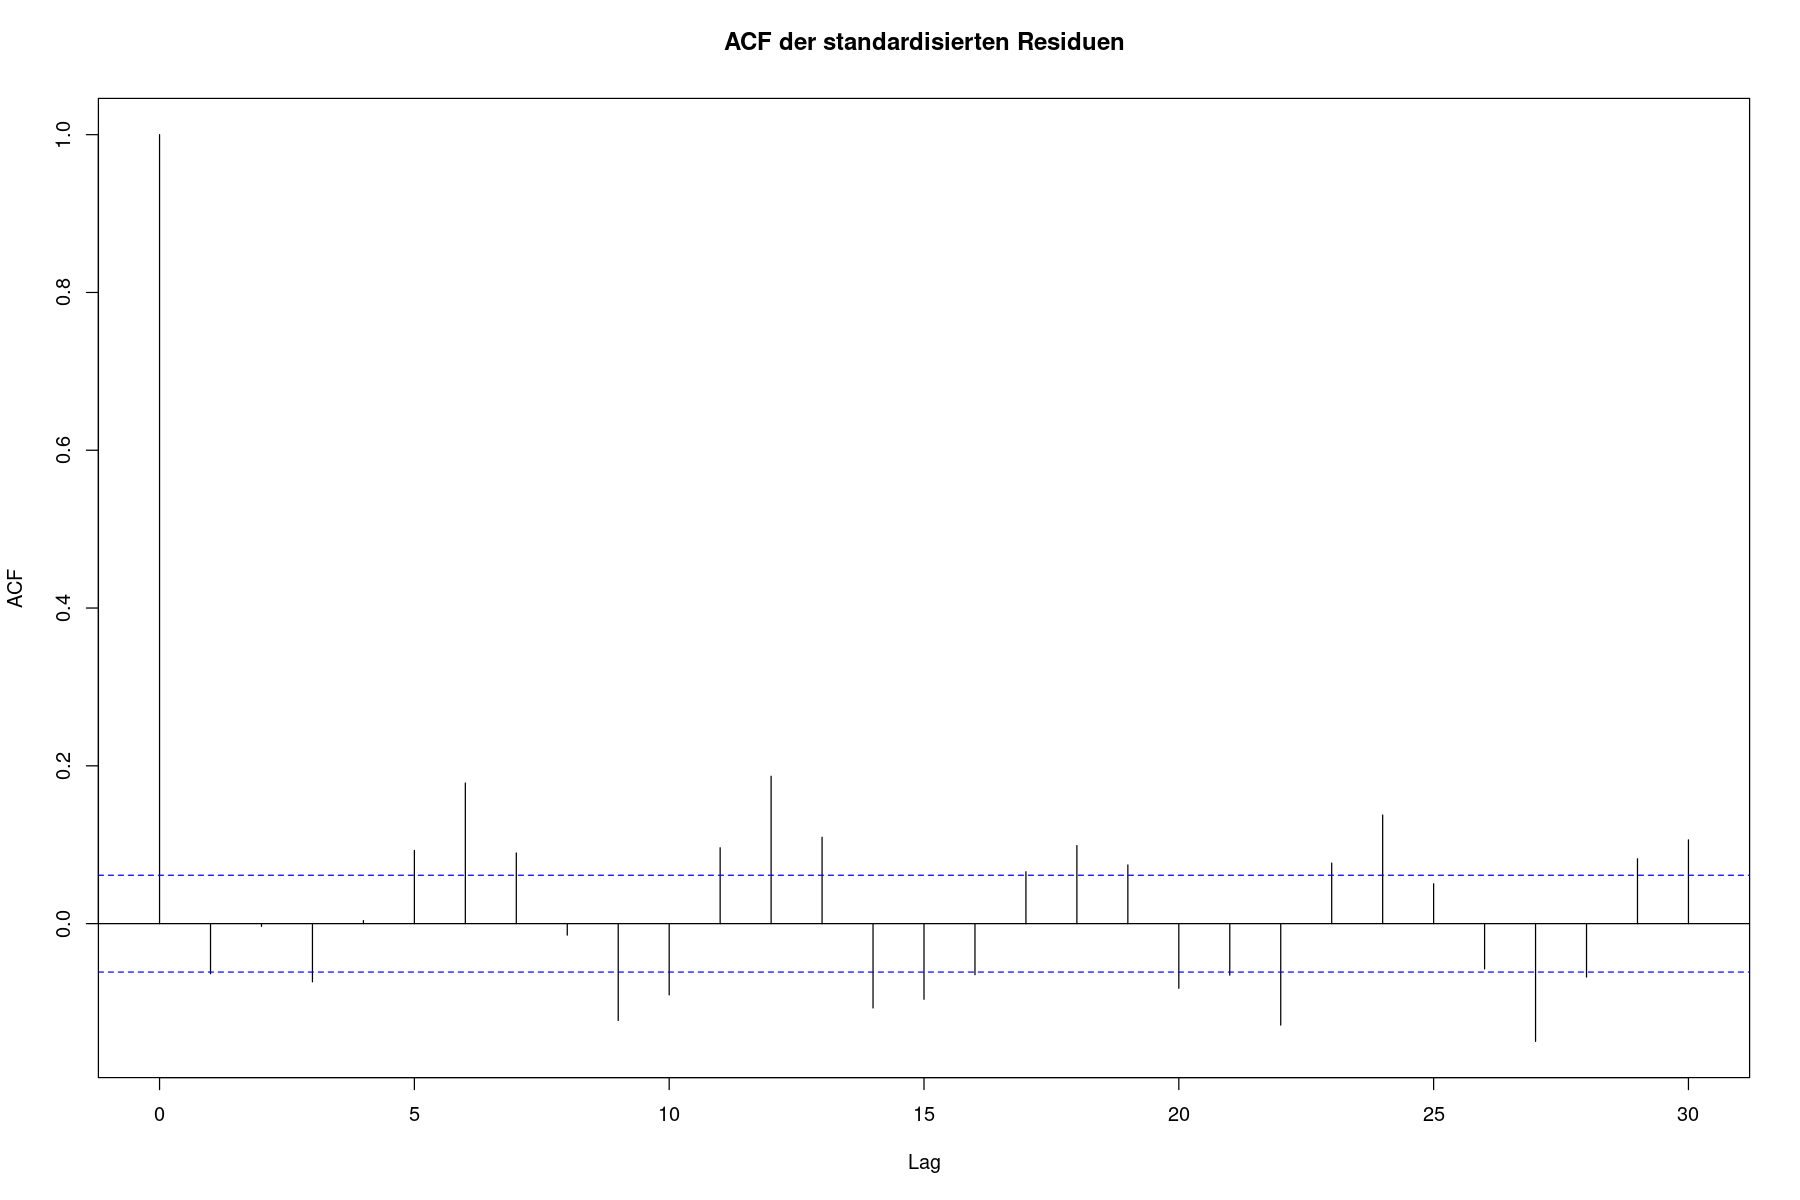

In [35]:
std_resid <- resid(lmod_seas_monthly, type = "normalized")
# “normalized” residuum sind so skaliert, dass sie etwa std-norm verteilt sein sollten.

# 2a) Shapiro-Wilk-Test auf Normalität der standardisierten Residuen
shapiro_std <- shapiro.test(std_resid)
cat("Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 \n")
print(shapiro_std)
par(bg = "white")
qqnorm(std_resid, main = "QQ-Plot der standardisierten GLS-Residuen")
qqline(std_resid, col = "red", lwd = 2)
plot(lmod_seas_monthly)
acf(std_resid, main = "ACF der standardisierten Residuen")


Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”
Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”
Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”
Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”
Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”


Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”
Warning message in angles_ext[(m + 1):(2 * n)] - angles_ext[1:(n)]:
“Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes”


pdf 
  2

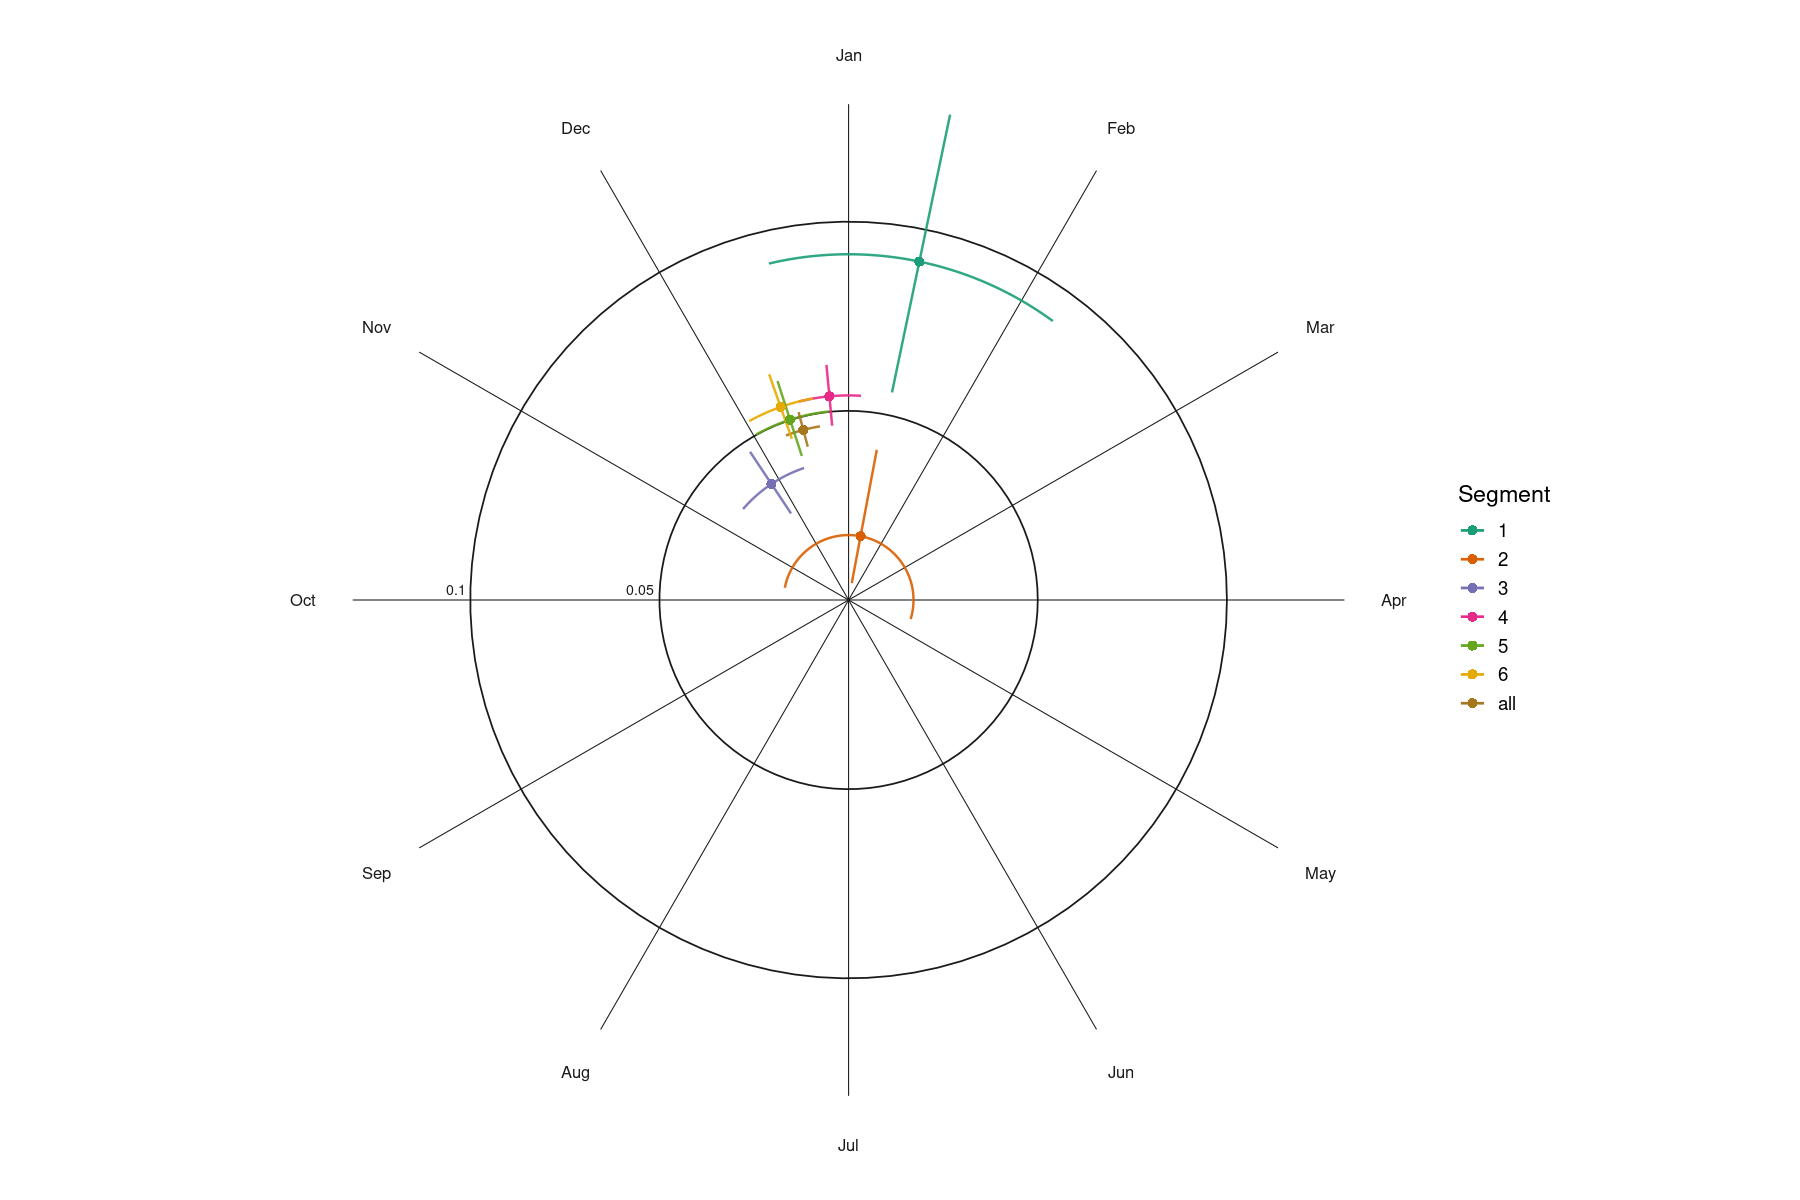

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 5. Usage example
# ─────────────────────────────────────────────────────────────────────────────
df_ci_combined <- bind_rows(
    get_seasonal_CI(lmod_seas_monthly, B = N_PERM),
    get_seasonal_CI(seasonal_model, B = N_PERM)
) %>%
    filter(n() > 0)

if (nrow(df_ci_combined) > 0) {
    p <- plot_seasonal_polar(df_ci_combined)
    print(p)
    save_plot(p, "SeasonalCyclePolarLarge.pdf", width = 6, height = 5)
} else {
    message("No seasonal parameters found in models")
}


# Watch our for Autocorrelation!
**All models fitted exhibit autocorrelation to a significant degree. This comes as no surprise, but demands choosing ARIMA over ordinary least squares**

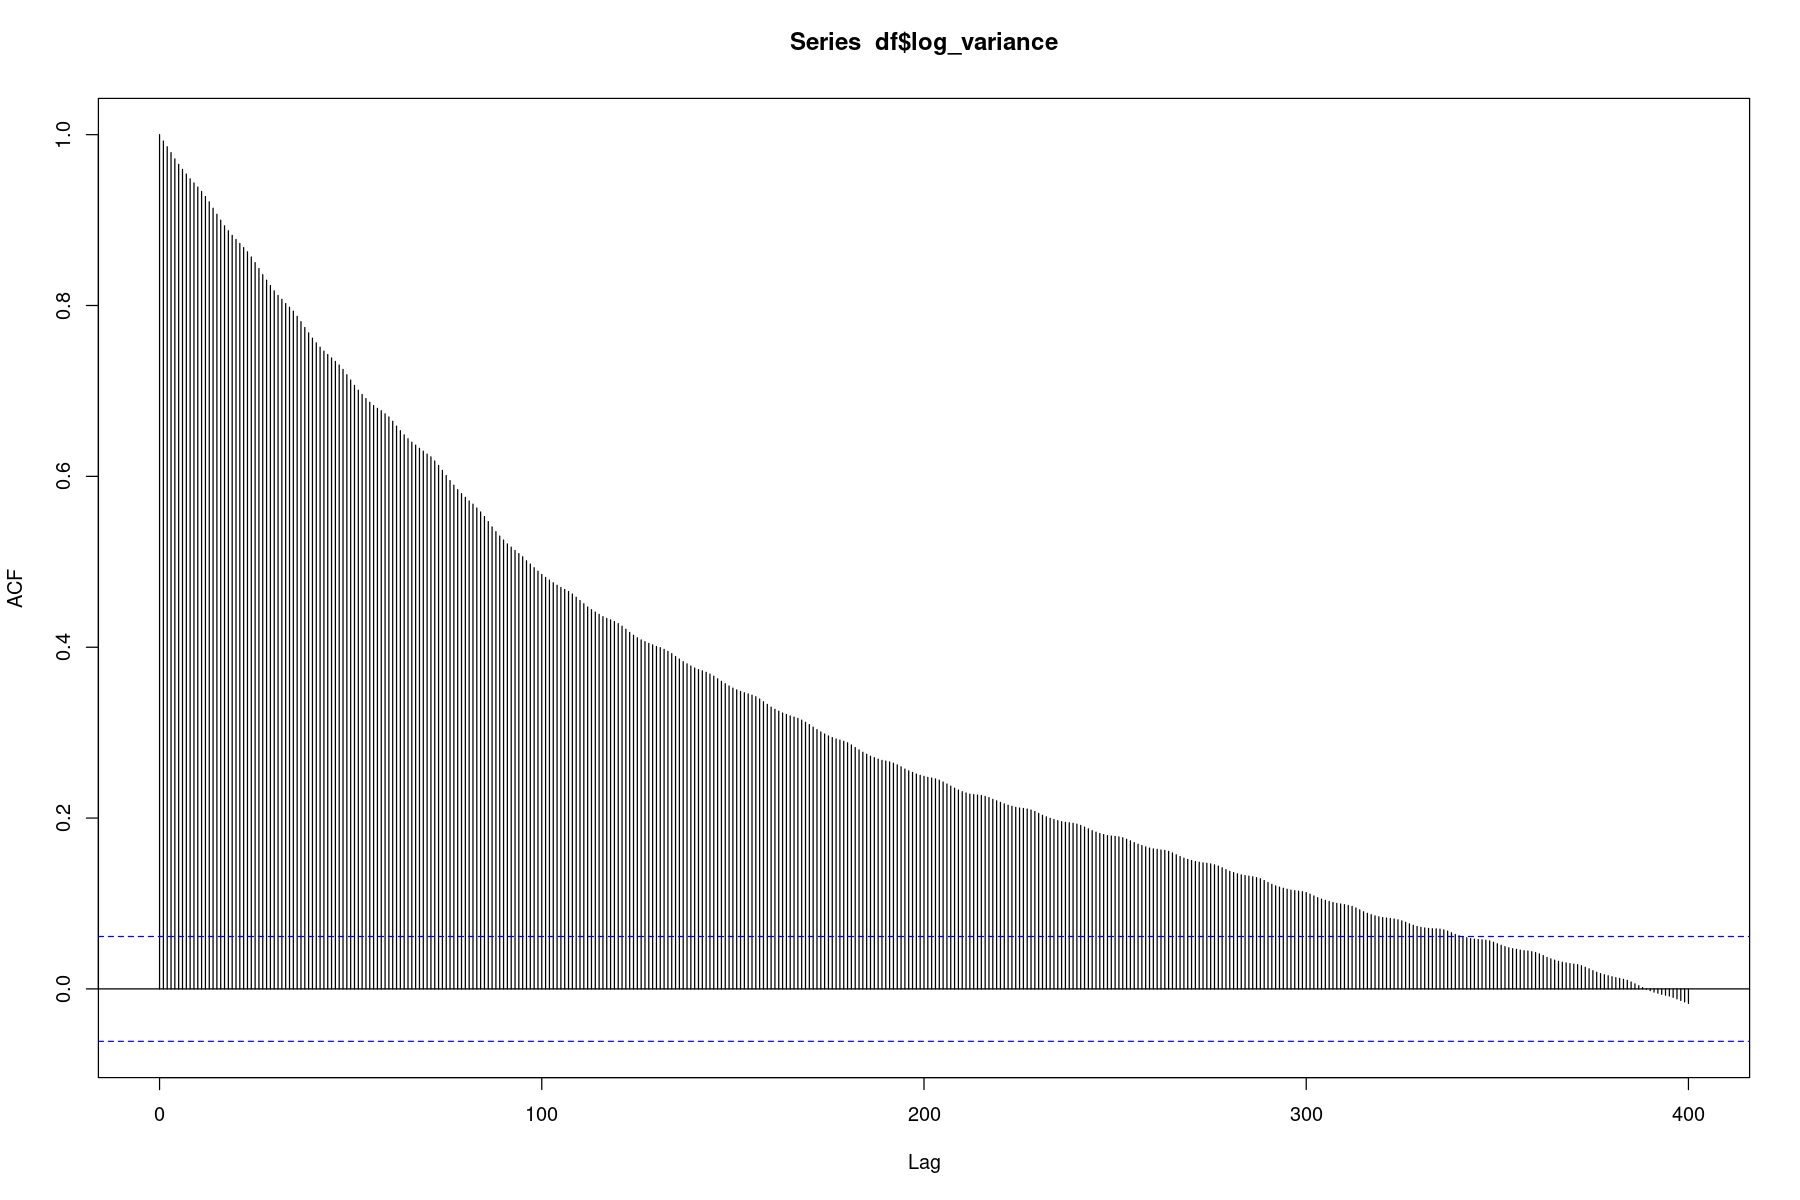

In [10]:
par(bg = "white")
plot(acf(df$log_variance, lag.max = 400))
# plot(acf(residuals(seasonal_model), lag.max = 30))
# plot(acf(residuals(lmod_seas_monthly), lag.max = 30))


## Explicitly allow ar coeff to vary across break points and assume ar is in the mean

In [14]:
df <- df %>% mutate(lag1 = dplyr::lag(log_variance, 1))



	 Optimal 4-segment partition: 

Call:
breakpoints.formula(formula = log_variance ~ year + sin_mon + 
    cos_mon + lag1, h = 0.1, breaks = NULL, data = df)

Breakpoints at observation number:
108 227 469 

Corresponding to breakdates:
0.1059863 0.2227674 0.4602552 

	 Confidence intervals for breakpoints
	 of optimal 4-segment partition: 

Call:
confint.breakpointsfull(object = bp_ar, level = 0.95, het.reg = TRUE, 
    het.err = TRUE, vcov. = sandwich::NeweyWest, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   107         108    109
2   226         227    228
3   468         469    495

Corresponding to breakdates:
      2.5 % breakpoints    97.5 %
1 0.1050049   0.1059863 0.1069676
2 0.2217861   0.2227674 0.2237488
3 0.4592738   0.4602552 0.4857704
  2.5 % breakpoints 97.5 %
1   107         108    109
2   226         227    228
3   468         469    495
            
108 227 469 
[1] 1 2 3
[1] 1 2 3


,cp_date,cp_date_lower,cp_date_upper,ci_width_obs,cp_no
,<date>,<date>,<date>,<dbl>,<int>
1,1948-12-01,1948-11-01,1949-01-01,2,1
2,1958-11-01,1958-10-01,1958-12-01,2,2
3,1979-01-01,1978-12-01,1981-03-01,27,3


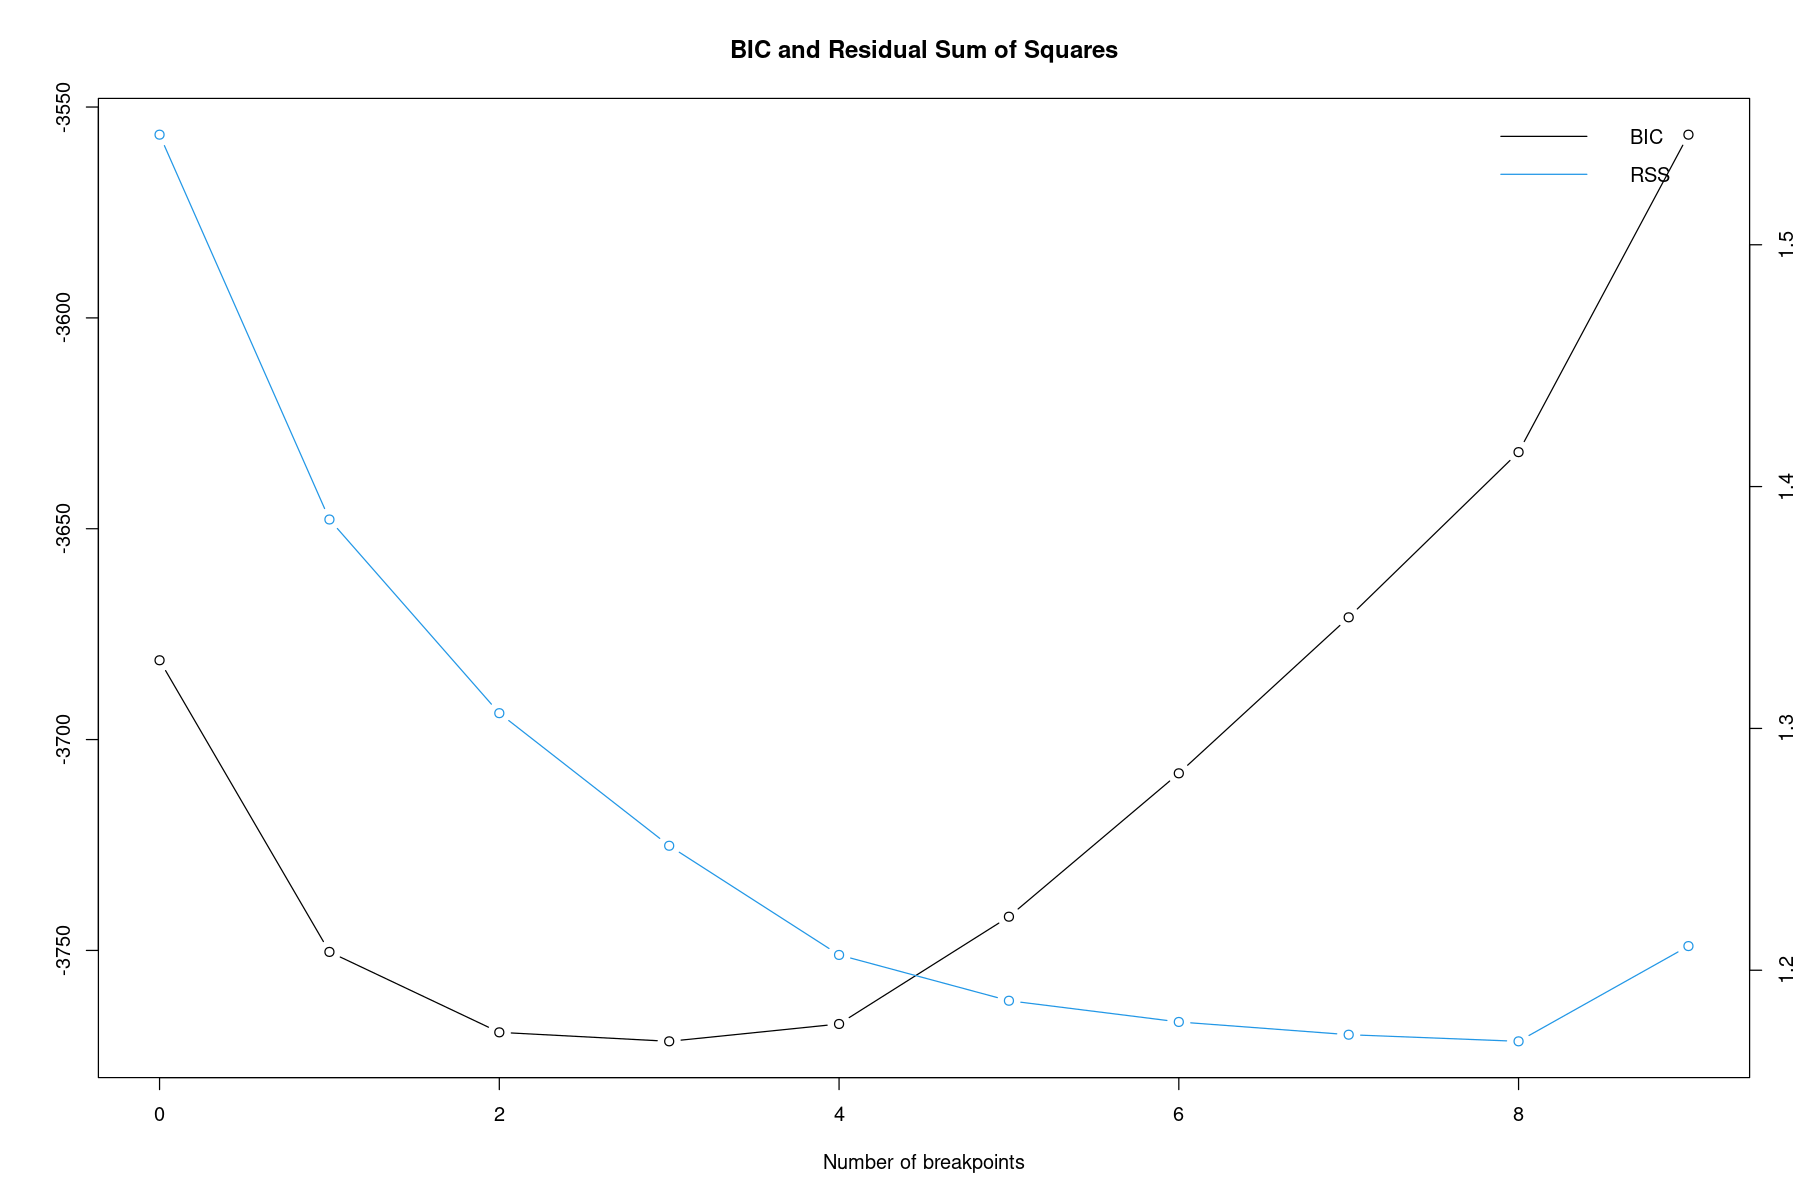

In [15]:
bp_ar <- breakpoints(log_variance ~ year + sin_mon + cos_mon + lag1,
    data = df,
    h = .1,
    breaks = NULL
)

par(bg = "white")
plot(bp_ar)
print(bp_ar)
print(confint(bp_ar,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = sandwich::NeweyWest,
    level = 0.95
))
cp_df <- ordered_cp_df(bp_ar, df)
cp_df


In [16]:
pdf(paste0(OUT_DIR, "BIC_breakpointsAR.pdf"), width = 4, height = 3)
plot(bp_ar)
dev.off()


pdf 
  2

In [17]:
df$segment_ar <- factor(
    c(
        as.character(breakfactor(bp_ar)),
        tail(as.character(breakfactor(bp_ar)), 1)
    ),
    levels = levels(breakfactor(bp_ar))
)

df_ar <- df %>% filter(!is.na(lag1))

# Fit the segmented linear model with segment-specific predictors
lmod_seas_ar <- nlme::gls(
    log_variance ~ segment_ar +
        segment_ar:year + segment_ar:sin_mon + segment_ar:cos_mon +
        -1, # segment_ar:lag1 - 1,
    data = df_ar,
    weights = varIdent(form = ~ 1 | segment_ar)
)

# Summarize the segmented model results
summary(lmod_seas_ar)


Generalized least squares fit by REML
  Model: log_variance ~ segment_ar + segment_ar:year + segment_ar:sin_mon +      segment_ar:cos_mon + -1 
  Data: df_ar 
        AIC       BIC   logLik
  -2739.711 -2641.496 1389.856

Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_ar 
 Parameter estimates:
 segment1  segment2  segment3  segment4 
1.0000000 0.4324780 0.3121455 0.5888194 

Coefficients:
                               Value Std.Error   t-value p-value
segment_arsegment1         303.76724  8.208040  37.00850  0.0000
segment_arsegment2         126.16433  3.039032  41.51464  0.0000
segment_arsegment3          29.20067  0.759907  38.42664  0.0000
segment_arsegment4          34.36802  0.424268  81.00538  0.0000
segment_arsegment1:year     -0.15379  0.004222 -36.42371  0.0000
segment_arsegment2:year     -0.06272  0.001556 -40.31661  0.0000
segment_arsegment3:year     -0.01319  0.000386 -34.17894  0.0000
segment_arsegment4:year     -0.01586  0

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


pdf 
  2

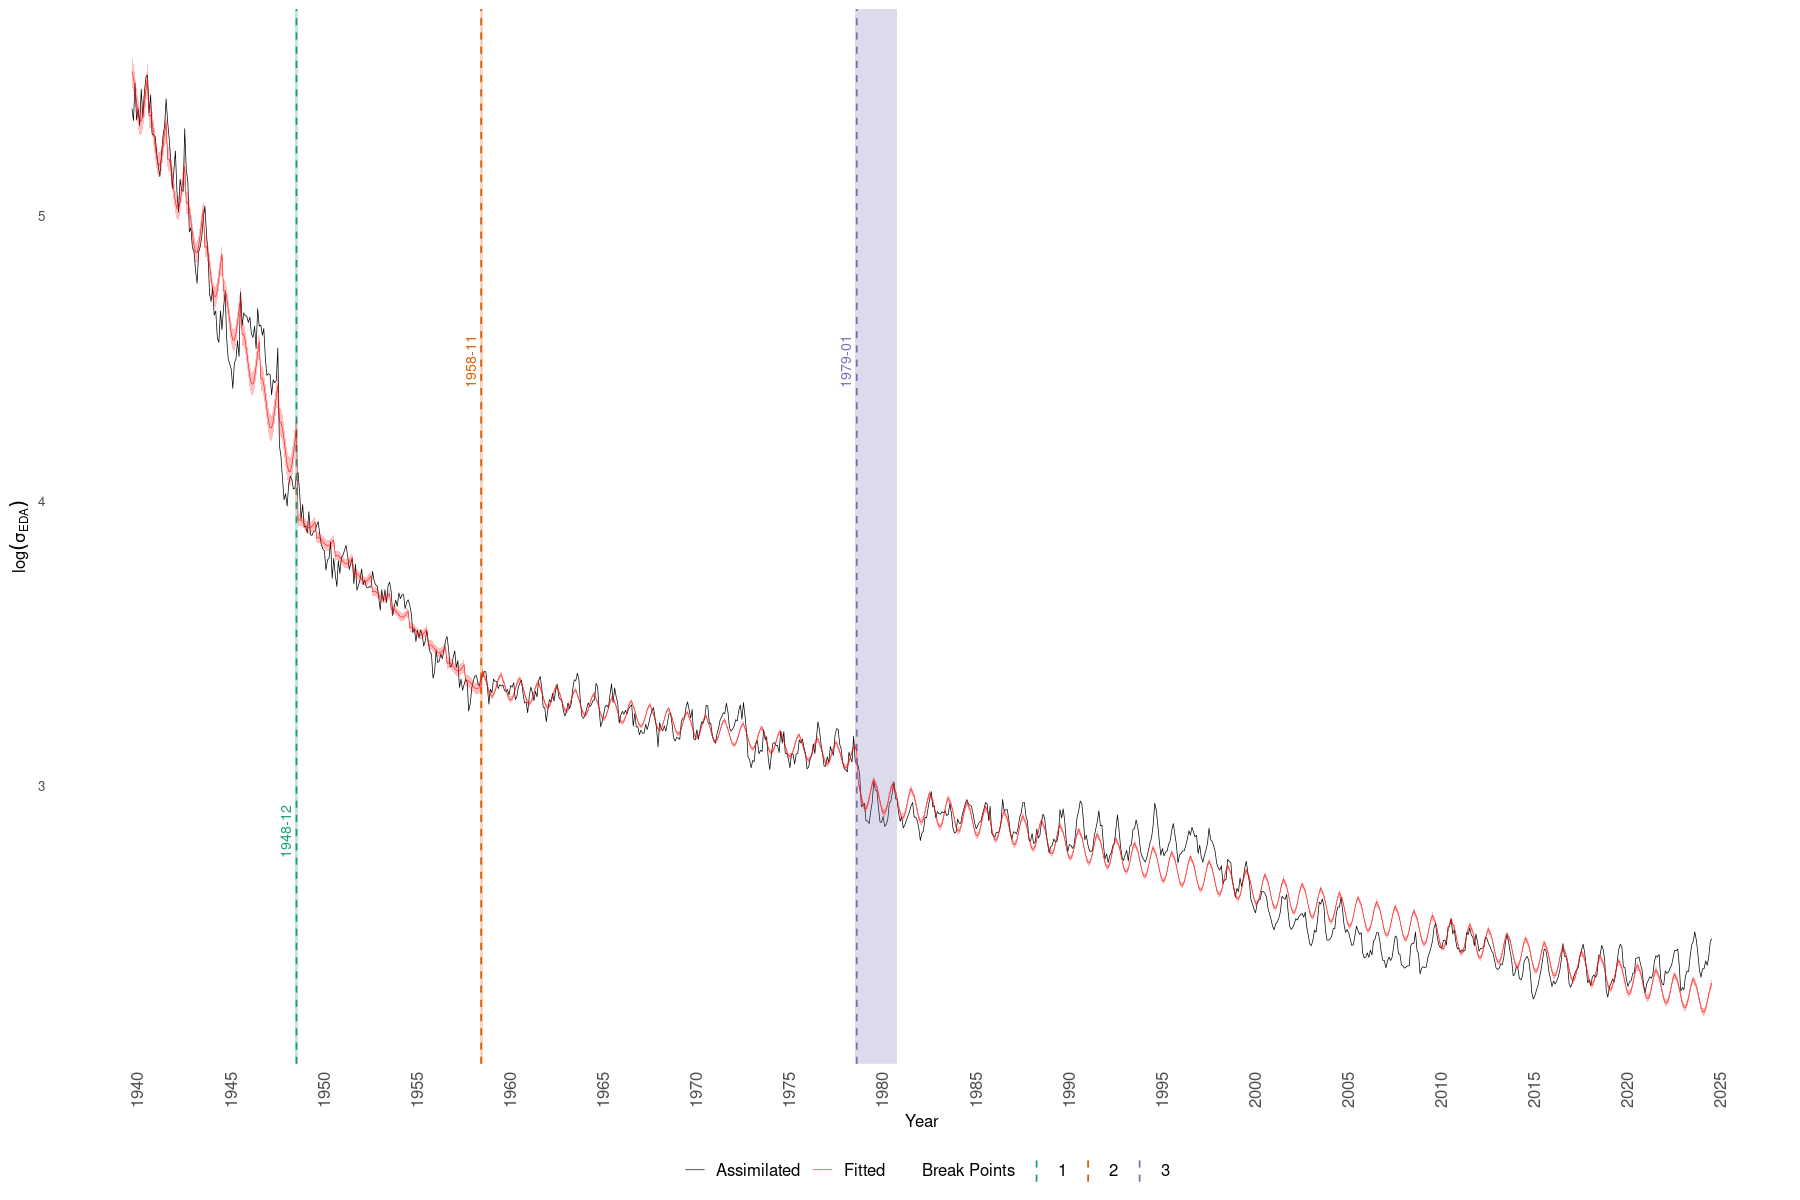

In [18]:
p <- plot_change_points(
    data = df_ar,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE,
    title = NULL
)

fitted_layers <- add_fitted_line_ci(lmod_seas_ar, df_ar)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
) #+ THEME_PUB

p

save_plot(p, "ChangePointsAR.pdf", width = 7, height = 4)


## Binary Segmentation
- legacy code because breakpoints in regressions is more suitable

In [ ]:
flattened_data <- combined_dataset$avg_z
log_data <- log(flattened_data)

#---------------- Change Point Detection and Plotting ------------------------
max_cp_vec <- 1:4

# Prepare an empty data frame to accumulate change point info:
# cp_index: index in the time series
# cp_date: the corresponding date
# max_cp: the hierarchical level (i.e. the iteration when first found)
cp_df <- data.frame(
    cp_index = integer(),
    cp_date = as.Date(character()),
    max_cp = integer(),
    stringsAsFactors = FALSE
)

# Loop over each max_cp value and detect change points hierarchically.
for (i in seq_along(max_cp_vec)) {
    max_cp <- max_cp_vec[i]
    cpt_obj <- cpt.mean(log_data,
        method = "BinSeg", Q = max_cp,
        class = TRUE
    )
    # cpts() returns the indices of the change points (including the final index)
    cps <- cpts(cpt_obj)
    cps <- cps[cps < length(flattened_data)]

    # Save only newly found change points
    new_cps <- cps[!cps %in% cp_df$cp_index]

    if (length(new_cps) > 0) {
        for (cp in new_cps) {
            cp_df <- rbind(
                cp_df,
                data.frame(
                    cp_index = cp,
                    cp_date = combined_dataset$date[cp],
                    max_cp = max_cp,
                    stringsAsFactors = FALSE
                )
            )
        }
        cat(
            "Max change points:", max_cp,
            "-> New cp detected at indices:", paste(new_cps, collapse = ", "),
            "which correspond to dates:",
            paste(as.character(combined_dataset$date[new_cps]),
                collapse = ", "
            ), "\n"
        )
    } else {
        cat(
            "Max change points:", max_cp,
            "-> No new change points detected.\n"
        )
    }
}

#--- Build the base plot using actual date values on the x-axis ---------------
p <- ggplot(data = combined_dataset, aes(x = date, y = avg_z)) +
    geom_line() +
    scale_y_log10() +
    labs(
        x = "Time", y = "Log(Var)",
        title = "Original Data with Detected Change Points",
        color = "Hierarchy"
    ) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    THEME_PUB +
    scale_x_date(date_breaks = "5 year", date_labels = "%Y") +
    scale_color_scico_d(palette = "batlow") # discrete colour scale

#--- Add vertical lines and annotations for change points --------------------
if (nrow(cp_df) > 0) {
    y_pos <- max(combined_dataset$avg_z, na.rm = TRUE) * .7
    p <- p +
        geom_vline(
            data = cp_df, aes(
                xintercept = cp_date,
                color = factor(max_cp)
            ),
            linetype = "dashed", linewidth = 1
        ) +
        geom_text(
            data = cp_df, aes(
                x = cp_date, y = y_pos,
                label = format(cp_date, "%Y-%m"),
                color = factor(max_cp)
            ),
            angle = 90, vjust = -0.5, hjust = 0, size = 5, show.legend = FALSE
        ) +
        guides(color = guide_legend(
            override.aes = list(
                shape = NA,
                linetype = "dashed"
            )
        )) +
        theme(
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 18),
            legend.key.size = unit(2, "lines")
        )
}

#--- Display the plot ---------------------------------------------------------
print(p)

#--- Print out the exact time values (and indices) identified ----------------
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


In [ ]:
max_cp_vec <- 1:4

# Detect change points
cp_df <- detect_change_points(
    log_data,
    combined_dataset$date,
    max_cp_vec
)

# Create the plot (THEME_PUB can be passed if defined)
p <- plot_change_points(combined_dataset, cp_df, theme_pub = THEME_PUB)

# Display the plot
print(p)

# Print the detected change points
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}
